### MA6202: Laboratorio de Ciencia de Datos

#### Profesor: Nicolás Caro

#### Fecha de entrega: 17/05/2020

#### Integrantes: Matías Romero, Danner Schlotterbeck, Kurt Walsen

# Tarea 1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# P1 Limpieza de datos

## Parte 1

In [3]:
# Se carga una de las semanas de la data para inspeccionar:
w13_all = pd.read_csv('./data/raw/w{}/metrocuadrado_all_w{}.csv'.format(13,13))
w13_fur= pd.read_csv('./data/raw/w{}/metrocuadrado_furnished_w{}.csv'.format(13,13))

In [4]:
# Inspeccionamos sus columnas, y notamos que son las mismas
print(w13_all.columns)
print(w13_fur.columns)
w13_all.columns==w13_fur.columns

Index(['property_type|rent_type|location', 'price', 'n_rooms', 'n_bath',
       'surface', 'details', 'url', 'metrocuadrado_index'],
      dtype='object')
Index(['property_type|rent_type|location', 'price', 'n_rooms', 'n_bath',
       'surface', 'details', 'url', 'metrocuadrado_index'],
      dtype='object')


array([ True,  True,  True,  True,  True,  True,  True,  True])

In [5]:
'''Realizamos una concatenación con y sin duplicados para verificar la 
existencia de éstos.
'''
df_con=pd.concat([w13_all,w13_fur],ignore_index=True)
df_con.head()

,property_type|rent_type|location,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index
0,"Casa en Arriendo, LA SOLEDAD NORTE Bogotá D.C..",$1.050.000,3,2,63.0 m2,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6
1,"Casa en Arriendo, CIUDAD SALITRE SUR-ORIENTAL ...",$3.930.000,3,2,100.0 m2,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3
2,"Casa en Arriendo, VILLA DE LOS ALPES II SECTOR...",$750.000,3,1,90.0 m2,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2
3,"Casa en Arriendo, PARIS GAITAN Bogotá D.C..",$3.400.000,5,4,71.0 m2,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0
4,"Casa en Arriendo, BALCONES DE ORIENTE Bogotá D...",$1.560.000,4,3,96.0 m2,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1


In [6]:
# Verificamos si existen duplicados
df_con.shape[0]==df_con.drop_duplicates().shape[0] # False, luego existen.

False

In [7]:
'''
Buscamos generar una variable categórica que indique si la observación
correspondiente proviene de un archivo que en su nombre contiene `furnished`.
Para ello haremos uso de la función merge.

Notamos que la columna que sirve de identificador es `url` pues debiese 
ser único para cada propiedad en arriendo. Además podemos utilizarlo como llave
para hacer el merge de los dataframes y ver qué ocurre con al columna
`furnished`.

De esta manera identificamos a archivos de texto `furnished` que no estén
contenidos en archivos con texto `all` mediante la inspección de los valores
right_only en la columna 'furnished'.
'''
w13_all = w13_all.drop_duplicates()
w13_fur = w13_fur.drop_duplicates()


df_mer = pd.merge(left=w13_all,right=w13_fur,on='url',how='outer',indicator='furnished')
df_mer

,property_type|rent_type|location_x,price_x,n_rooms_x,n_bath_x,surface_x,details_x,url,metrocuadrado_index_x,property_type|rent_type|location_y,price_y,n_rooms_y,n_bath_y,surface_y,details_y,metrocuadrado_index_y,furnished
0,"Casa en Arriendo, LA SOLEDAD NORTE Bogotá D.C..",$1.050.000,3,2,63.0 m2,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,"Casa en Arriendo, CIUDAD SALITRE SUR-ORIENTAL ...",$3.930.000,3,2,100.0 m2,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,"Casa en Arriendo, CIUDAD SALITRE SUR-ORIENTAL ...",$3.930.000,3.0,2.0,100.0 m2,Se arrienda casa bonita totalmente amoblada co...,57.3,both
2,"Casa en Arriendo, VILLA DE LOS ALPES II SECTOR...",$750.000,3,1,90.0 m2,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,"Casa en Arriendo, PARIS GAITAN Bogotá D.C..",$3.400.000,5,4,71.0 m2,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,"Casa en Arriendo, BALCONES DE ORIENTE Bogotá D...",$1.560.000,4,3,96.0 m2,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11956,NaN,NaN,NaN,NaN,NaN,NaN,https://www.metrocuadrado.com/inmueble/arriend...,NaN,"Casa en Arriendo, SANTA HELENA I Bogotá D.C..",$3.233.000,3.0,4.0,202.0 m2,Casa tres niveles conjunto cerrado. Área de 20...,25.2,right_only
11957,NaN,NaN,NaN,NaN,NaN,NaN,https://www.metrocuadrado.com/inmueble/arriend...,NaN,"Casa en Arriendo, ATAHUALPA Bogotá D.C..",$5.500.000,4.0,3.0,220.0 m2,"Hermosa casa para sede educativa,o fundación,d...",66.8,right_only
11958,NaN,NaN,NaN,NaN,NaN,NaN,https://www.metrocuadrado.com/inmueble/arriend...,NaN,"Casa en Arriendo, JULIO FLOREZ Bogotá D.C..",$2.900.000,4.0,4.0,216.0 m2,Arriendo Casa La Floresta en dos Niveles y un ...,33.8,right_only
11959,NaN,NaN,NaN,NaN,NaN,NaN,https://www.metrocuadrado.com/inmueble/arriend...,NaN,"Apartamento en Arriendo, SANTA BIBIANA Bogotá ...",$1.900.000,1.0,2.0,47.0 m2,Aparta-estudio amoblado en arriendo sector res...,37.5,right_only


In [8]:
'''Para w13 podemos notar 5 de éstos casos. Pero hay que verlo para el caso
general.
'''
fur=df_mer.drop_duplicates()[['url','furnished']]
fur[fur['furnished']=='right_only']

,url,furnished
11956,https://www.metrocuadrado.com/inmueble/arriend...,right_only
11957,https://www.metrocuadrado.com/inmueble/arriend...,right_only
11958,https://www.metrocuadrado.com/inmueble/arriend...,right_only
11959,https://www.metrocuadrado.com/inmueble/arriend...,right_only
11960,https://www.metrocuadrado.com/inmueble/arriend...,right_only


In [9]:
'''Ahora, agregamos al dataframe de concatenación la columna con la variable
categórica furnished, mediante el uso de merge nuevamente.
'''
df_con = df_con.drop_duplicates()
pd.merge(df_con,fur,on='url').drop_duplicates()

,property_type|rent_type|location,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,furnished
0,"Casa en Arriendo, LA SOLEDAD NORTE Bogotá D.C..",$1.050.000,3,2,63.0 m2,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only
1,"Casa en Arriendo, CIUDAD SALITRE SUR-ORIENTAL ...",$3.930.000,3,2,100.0 m2,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both
2,"Casa en Arriendo, CIUDAD SALITRE SUR-ORIENTAL ...",$3.930.000,3,2,100.0 m2,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both
3,"Casa en Arriendo, VILLA DE LOS ALPES II SECTOR...",$750.000,3,1,90.0 m2,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only
4,"Casa en Arriendo, PARIS GAITAN Bogotá D.C..",$3.400.000,5,4,71.0 m2,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,left_only
...,...,...,...,...,...,...,...,...,...
13561,"Casa en Arriendo, SANTA HELENA I Bogotá D.C..",$3.233.000,3,4,202.0 m2,Casa tres niveles conjunto cerrado. Área de 20...,https://www.metrocuadrado.com/inmueble/arriend...,25.2,right_only
13562,"Casa en Arriendo, ATAHUALPA Bogotá D.C..",$5.500.000,4,3,220.0 m2,"Hermosa casa para sede educativa,o fundación,d...",https://www.metrocuadrado.com/inmueble/arriend...,66.8,right_only
13563,"Casa en Arriendo, JULIO FLOREZ Bogotá D.C..",$2.900.000,4,4,216.0 m2,Arriendo Casa La Floresta en dos Niveles y un ...,https://www.metrocuadrado.com/inmueble/arriend...,33.8,right_only
13564,"Apartamento en Arriendo, SANTA BIBIANA Bogotá ...",$1.900.000,1,2,47.0 m2,Aparta-estudio amoblado en arriendo sector res...,https://www.metrocuadrado.com/inmueble/arriend...,37.5,right_only


In [10]:
'''Se compara con el DataFrame sin la columna agregada, se observa que poseen
la misma cantidad de registros.
'''
df_con

,property_type|rent_type|location,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index
0,"Casa en Arriendo, LA SOLEDAD NORTE Bogotá D.C..",$1.050.000,3,2,63.0 m2,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6
1,"Casa en Arriendo, CIUDAD SALITRE SUR-ORIENTAL ...",$3.930.000,3,2,100.0 m2,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3
2,"Casa en Arriendo, VILLA DE LOS ALPES II SECTOR...",$750.000,3,1,90.0 m2,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2
3,"Casa en Arriendo, PARIS GAITAN Bogotá D.C..",$3.400.000,5,4,71.0 m2,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0
4,"Casa en Arriendo, BALCONES DE ORIENTE Bogotá D...",$1.560.000,4,3,96.0 m2,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1
...,...,...,...,...,...,...,...,...
13612,"Apartamento en Arriendo, SANTA BARBARA OCCIDEN...",$4.500.000,2,3,136.0 m2,"EXCELENTE APARTAMENTO AMOBLADO, ALCOBAS CON PI...",https://www.metrocuadrado.com/inmueble/arriend...,64.1
13613,"Apartamento en Arriendo, SANTA BARBARA OCCIDEN...",$4.390.000,2,3,110.0 m2,amoblado con terraza.,https://www.metrocuadrado.com/inmueble/arriend...,64.2
13614,"Apartamento en Arriendo, ANTIGUO COUNTRY Bogot...",$4.500.000,2,3,120.0 m2,"Lindo apto en el sector de Chico Virrey, cerca...",https://www.metrocuadrado.com/inmueble/arriend...,55.4
13615,"Apartamento en Arriendo, MOLINOS NORTE Bogotá ...",$4.100.000,2,3,114.0 m2,"Hermoso apto, rodeado de verde por todos lados...",https://www.metrocuadrado.com/inmueble/arriend...,59.1


In [11]:
w13_fur.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1610 entries, 0 to 1609
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   property_type|rent_type|location  1610 non-null   object 
 1   price                             1610 non-null   object 
 2   n_rooms                           1609 non-null   float64
 3   n_bath                            1607 non-null   float64
 4   surface                           1610 non-null   object 
 5   details                           1602 non-null   object 
 6   url                               1610 non-null   object 
 7   metrocuadrado_index               1610 non-null   float64
dtypes: float64(3), object(5)
memory usage: 113.2+ KB


In [12]:
w13_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11956 entries, 0 to 12006
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   property_type|rent_type|location  11956 non-null  object 
 1   price                             11956 non-null  object 
 2   n_rooms                           11931 non-null  object 
 3   n_bath                            11771 non-null  object 
 4   surface                           11956 non-null  object 
 5   details                           11862 non-null  object 
 6   url                               11956 non-null  object 
 7   metrocuadrado_index               11956 non-null  float64
dtypes: float64(1), object(7)
memory usage: 840.7+ KB


In [13]:
# Para unificar formatos, pasamos las columnas 'n_rooms' y 'n_bath' de _fur a string.
w13_fur.n_rooms=w13_fur.n_rooms.astype(str)
w13_fur.n_bath=w13_fur.n_bath.astype(str)
w13_fur.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1610 entries, 0 to 1609
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   property_type|rent_type|location  1610 non-null   object 
 1   price                             1610 non-null   object 
 2   n_rooms                           1610 non-null   object 
 3   n_bath                            1610 non-null   object 
 4   surface                           1610 non-null   object 
 5   details                           1602 non-null   object 
 6   url                               1610 non-null   object 
 7   metrocuadrado_index               1610 non-null   float64
dtypes: float64(1), object(7)
memory usage: 113.2+ KB


In [14]:
'''Ahora, realizamos el proceso general para todas las semanas disponibles
en la data.
'''
# Se concatenan todos los _all
df_all = pd.concat([pd.read_csv('./data/raw/w{}/metrocuadrado_all_w{}.csv'.format(i,i)) for i in range(13,18)])
print('Número de registros en df_all: '+str(len(df_all)))
df_all.drop_duplicates(inplace=True)
print('Número de registros en df_all sin duplicados: '+str(len(df_all)))

# Se concatenan todos los _fur
df_fur = pd.concat([pd.read_csv('./data/raw/w{}/metrocuadrado_furnished_w{}.csv'.format(i,i)) for i in range(13,18)])
print('Número de registros en df_fur: '+str(len(df_fur)))
df_fur.drop_duplicates(inplace=True)
df_fur.reset_index()
print('Número de registros en df_fur sin duplicados: '+str(len(df_fur)))

furnished_only = df_fur.query("url not in @df_all.url")
print("Observaciones de archivos con texto 'furnished' que no estén\n contenidos en archivos con texto 'all': ",
      len(furnished_only))
# Se agregan los que estan solo en furnished
df = pd.concat([df_all, df_fur.query("url not in @df_all.url")],ignore_index=True)

# Se crea columna dummy y se le asigna valor 1 a los que se encontraban en archivos furnished
from_furnished = df.query("url in @df_fur.url").index
df.loc[:, 'furnished'] = np.zeros(len(df), dtype=int)
df.loc[from_furnished, 'furnished'] = 1

Número de registros en df_all: 57167
Número de registros en df_all sin duplicados: 16295
Número de registros en df_fur: 7850
Número de registros en df_fur sin duplicados: 2099
Observaciones de archivos con texto 'furnished' que no estén
 contenidos en archivos con texto 'all':  4


In [15]:
df

,property_type|rent_type|location,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,furnished
0,"Casa en Arriendo, LA SOLEDAD NORTE Bogotá D.C..",$1.050.000,3,2,63.0 m2,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0
1,"Casa en Arriendo, CIUDAD SALITRE SUR-ORIENTAL ...",$3.930.000,3,2,100.0 m2,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,1
2,"Casa en Arriendo, VILLA DE LOS ALPES II SECTOR...",$750.000,3,1,90.0 m2,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0
3,"Casa en Arriendo, PARIS GAITAN Bogotá D.C..",$3.400.000,5,4,71.0 m2,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0
4,"Casa en Arriendo, BALCONES DE ORIENTE Bogotá D...",$1.560.000,4,3,96.0 m2,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0
...,...,...,...,...,...,...,...,...,...
16294,"Apartamento en Arriendo, CHICO NORTE III Bogot...",$2.750.000,1,2,57.0 m2,Apartamento de una alcoba. Edificio Naia (Ca...,https://www.metrocuadrado.com/inmueble/arriend...,81.1,1
16295,"Casa en Arriendo, CIUDAD SALITRE SUR-ORIENTAL ...",$3.750.000,3,2,117.0 m2,Hermosa casa amoblada en arriendo ubicada en e...,https://www.metrocuadrado.com/inmueble/arriend...,66.4,1
16296,"Apartamento en Arriendo, LOS CEDRITOS Bogotá D...",$2.300.000,1,1,48.0 m2,Arriendo apartamento amoblado nuevo moderno ti...,https://www.metrocuadrado.com/inmueble/arriend...,72.7,1
16297,"Apartamento en Arriendo, SANTA BIBIANA Bogotá ...",$2.600.000,1,2,60.0 m2,"Se arrienda precioso apartamento amoblado, con...",https://www.metrocuadrado.com/inmueble/arriend...,63.4,1


## Parte 2

In [16]:
'''Se procede a limpiar parte de la data, esto incluye cambiar el formato
de ciertas variables de interés. En particular:

- 'price' : Se decidió expresar la columna de precios como un número flotante,
            para evitar posibles futuras complicaciones en la inferencia 
            estadística.
            
- 'n_rooms' : Se decidió expresar la columna de número de habitaciones como 
              str, pues debido a la forma de los valores en esta columna
              es posible categorizarlas en base a la cantidad de baños 
              que registra, de esta manera los datos del tipo '5+' serán
              parte de una única categoría.
- 'n_bath' : Análogo a 'n_rooms'.
              
'''
# Se actualiza la columna 'price'
df['price'] = df['price'].str.replace('.','').str.strip('$').map(float)

# Se genera un diccionario de reemplazos
repl_dic = {1.0:'1',2.0:'2',3.0:'3',4.0:'4',5.0:'5'}

# Se actualizan las columnas 'n_rooms' y 'n_bath'
df['n_rooms'] = df['n_rooms'].replace(repl_dic)
df['n_bath'] = df['n_bath'].replace(repl_dic)


'''Se procede a separar el contenido de la columna 
'property_type|rent_type|location' en tres nuevas columnas 'property_type', 
'rent_type' y 'location'.
'''
# Preparamos la columna a tratar
newcols = df['property_type|rent_type|location'].str.split(pat= ',',expand=True)

# Se generan las nuevas columnas
df['location'] = newcols[1]
df[['property_type','rent_type']]=newcols[0].str.lower().str.split(pat=' ',n=1,expand=True)
df.loc[:,'rent_type'] = df['rent_type'].str.lstrip('en ')


# Fijamos las columnas de df en orden
cols = ['property_type', 'rent_type', 'location', 'price', 'n_rooms',
        'n_bath', 'surface', 'details', 'url', 'metrocuadrado_index',
        'furnished']
# Actualizamos df
df = df[cols]

## Parte 3

In [17]:
'''Se procede a agregar las columnas 'price_per_m2' y 'n_garajes',donde:

- 'price_per_m2' : Representa el precio por metro cuadrado.

- 'n_garajes' : Representa el número de garajes.

'''
# Modificamos los valores de la columna 'surface' para que representen el
# valor en metros cuadrados como número flotante.

df['surface'] = df['surface'].replace('m2', '', regex=True).map(float)

# Generamos la nueva columna 'price_per_m2' 
df['price_per_m2'] = df['price'] / df['surface']



'''Para 'n_garajes' fue un proceso más complejo. Notamos que el str 
asociado a cada elemento en 'url' es de la siguiente forma:
'''
print(df['url'][0])

'''Sin embargo, este no es el caso de todas las url. En particular:
'''
print(df['url'][3])

https://www.metrocuadrado.com/inmueble/arriendo-casa-bogota-la-soledad-norte-3-habitaciones-2-banos-1-garajes/35-M1919
https://www.metrocuadrado.com/inmueble/arriendo-casa-bogota-paris-gaitan-5-habitaciones-4-banos/OCHE-04552802


C:\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [18]:
'''Luego, una manera intuitiva de obtener el número de garajes es separar el
str con el separador '-garajes' lo cual generará una lista de dos strings, 
luego podemos acceder al primer string de la lista y extraer el último elemento,
recuperando así el número de garajes.
Lo cual nos entrega los siguientes valores para 'n_garajes':
'''
df['n_garajes'] = df['url'].map(lambda string: string.split(sep='-garajes')[0][-1])

df['n_garajes'].unique()

array(['1', '4', '2', '3', '8', '9', '5', '6', '7', '0', '+'],
      dtype=object)

In [19]:
#ojo acá
print(df['url'][3])
df['n_garajes'][3]

https://www.metrocuadrado.com/inmueble/arriendo-casa-bogota-paris-gaitan-5-habitaciones-4-banos/OCHE-04552802


'2'

In [20]:
'''Notamos que aparece un elemento de la forma '+', luego al igual que
'n_rooms' y 'n_bath', existe una categoria que representa una cantidad
superior a cierto valor, la intuición nos dice que tal categoria
corresponde a '9+'.
En búsqueda de generalizar la transformación(y así incluir éste tipo de
categorías) se uso una lambda function distinta, dando como resultado 
lo siguiente:
'''
df['n_garajes'] = df['url'].map(lambda string: string.split(sep='-garajes')[0][-1] if string.split(sep='-garajes')[0][-1] !='+' else string.split(sep='-garajes')[0][-2:])
df['n_garajes'].unique()

array(['1', '4', '2', '3', '8', '9', '5', '6', '7', '0', '4+'],
      dtype=object)

In [21]:
'''Ésto nos muestra que la única categoria de la forma antes descrita 
corresponde solamente a '4+', algo confuso pues ya existen las categorías 5:9.
Notamos que la cantidad de datos que corresponden a éste tipo de categoría 
son 9. 
'''
print(len(df['n_garajes'][df['n_garajes']=='4+']))

9


In [22]:
'''Veamos ahora cúantos corresponden a las categorías >4, notamos 
que corresponden a 1010(bastante mayor en comparación a '4+').
'''
print(len(df['n_garajes'][df['n_garajes']>'4']))

1010


In [23]:
'''Sin embargo, notamos que la cantidad de datos que pueden representarse
en la categoría '4+' corresponden a 1010(notar que al computar '4+'>'4'
nos entrega True), una cifra bastante menor a los 16299 datos totales de
los cuales disponemos, más precisamente, tenemos que las variables que superan
la categoría '4' corresponden en promedio a 1010/6=168.3 por categoría, mientras 
que las variables en categoría '4' o inferior corresponden en promedio a 
(16299-1010)/5=3057.8 por categoría. En base a ésto, es correcto aseverar que
podemos agrupar las variables con categoria superior a '4' en una única 
categoría '4+', sin perder variabilidad en el feature 'n_garajes'.
Por lo tanto, generamos un diccionario que mapee todos las categorias
resultantes superiores a '4' en una única categoría '4+'.
'''
# Se genera diccionario de mapeos
map_dict={'+':'4+', '5':'4+', '6':'4+', '7':'4+', '8':'4+', '9':'4+'}

# Se genera la correcta columna 'n_garajes'
df['n_garajes'] = df['url'].map(lambda string: string[
    string.find('-garajes')-1] if string.find('-garajes') > 0 else np.nan )
df['n_garajes'] = df['n_garajes'].replace(map_dict)
df['n_garajes'].unique()

array(['1', nan, '2', '4', '3', '4+'], dtype=object)

In [24]:
# Fijamos el orden de las columnas en df.
cols = ['property_type', 'rent_type', 'location', 'price','price_per_m2', 
        'n_rooms', 'n_bath', 'n_garajes','surface', 'details', 'url', 
        'metrocuadrado_index', 'furnished']

# Reordenamos df.
df = df[cols]

In [25]:
df

,property_type,rent_type,location,price,price_per_m2,n_rooms,n_bath,n_garajes,surface,details,url,metrocuadrado_index,furnished
0,casa,arriendo,LA SOLEDAD NORTE Bogotá D.C..,1050000.0,16666.666667,3,2,1,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0
1,casa,arriendo,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,3930000.0,39300.000000,3,2,1,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,1
2,casa,arriendo,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,750000.0,8333.333333,3,1,NaN,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0
3,casa,arriendo,PARIS GAITAN Bogotá D.C..,3400000.0,47887.323944,5,4,NaN,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0
4,casa,arriendo,BALCONES DE ORIENTE Bogotá D.C..,1560000.0,16250.000000,4,3,1,96.0,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16294,apartamento,arriendo,CHICO NORTE III Bogotá D.C..,2750000.0,48245.614035,1,2,1,57.0,Apartamento de una alcoba. Edificio Naia (Ca...,https://www.metrocuadrado.com/inmueble/arriend...,81.1,1
16295,casa,arriendo,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,3750000.0,32051.282051,3,2,NaN,117.0,Hermosa casa amoblada en arriendo ubicada en e...,https://www.metrocuadrado.com/inmueble/arriend...,66.4,1
16296,apartamento,arriendo,LOS CEDRITOS Bogotá D.C..,2300000.0,47916.666667,1,1,1,48.0,Arriendo apartamento amoblado nuevo moderno ti...,https://www.metrocuadrado.com/inmueble/arriend...,72.7,1
16297,apartamento,arriendo,SANTA BIBIANA Bogotá D.C..,2600000.0,43333.333333,1,2,1,60.0,"Se arrienda precioso apartamento amoblado, con...",https://www.metrocuadrado.com/inmueble/arriend...,63.4,1


## Parte 4

In [26]:
'''Queremos categorizar los productos disponibles en la data según
el tipo de inmueble al que corresponde y la cantidad de m2 de 
superficie que poseen, para ello haremos uso de 12 categorias:

1 : 'rent_type' = 'casa' , 0 <= 'surface' < 80
2 : 'rent_type' = 'casa' , 80 <= 'surface' < 120
3 : 'rent_type' = 'casa' , 120 <= 'surface' < 180
4 : 'rent_type' = 'casa' , 180 <= 'surface' < 240
5 : 'rent_type' = 'casa' , 240 <= 'surface' < 360
6 : 'rent_type' = 'casa' , 360 <= 'surface' < 460
7 : 'rent_type' = 'casa' , 460 <= 'surface'
8 : 'rent_type' = 'apartamento' , 0 <= 'surface' < 40
9 : 'rent_type' = 'apartamento' , 40 <= 'surface' < 60
10 : 'rent_type' = 'apartamento' , 60 <= 'surface' < 80
11 : 'rent_type' = 'apartamento' , 80 <= 'surface' < 120
12 : 'rent_type' = 'apartamento' , 120 <= 'surface'

'''

# Se crea columna para ser rellenada a posteriori
df['product_type'] = np.repeat([np.nan], len(df))

# Se rellenan los tipos para las casas
#cotas_casas = [(1, 80),(80, 120), (120, 180), (180, 240), (240, 360), 
#               (360,460), (460, np.inf)]
cotas_casas = [(80, 120), (120, 180), (180, 240), (240, 360), 
               (360,460)]

for i in range(len(cotas_casas)):
    q = "(property_type == 'casa') & ({0} < surface <= {1})".format(*cotas_casas[i])
    idx = df.query(q).index
    df.loc[idx, 'product_type'] = str(i+1)

# Se rellenan los tipos para apartamentos    
#cotas_apartamentos = [(1,40),(40, 60), (60, 80), (80, 120),(120, np.inf)]
cotas_apartamentos = [(40, 60), (60, 80), (80, 120)]

for i in range(len(cotas_apartamentos)):
    q = "(property_type == 'apartamento') & ({0} < surface <= {1})".format(*cotas_apartamentos[i])
    idx = df.query(q).index
    df.loc[idx, 'product_type'] = str(i+(len(cotas_casas)+1))
    
print('Cantidad de productos no clasificados: '
      ,len(df[df['product_type'].isna()]))
print('Categorías: ',df['product_type'].unique())

Cantidad de productos no clasificados:  2953
Categorías:  [nan '1' '2' '3' '4' '5' '6' '7' '8']


In [27]:
df

,property_type,rent_type,location,price,price_per_m2,n_rooms,n_bath,n_garajes,surface,details,url,metrocuadrado_index,furnished,product_type
0,casa,arriendo,LA SOLEDAD NORTE Bogotá D.C..,1050000.0,16666.666667,3,2,1,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0,NaN
1,casa,arriendo,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,3930000.0,39300.000000,3,2,1,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,1,1
2,casa,arriendo,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,750000.0,8333.333333,3,1,NaN,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0,1
3,casa,arriendo,PARIS GAITAN Bogotá D.C..,3400000.0,47887.323944,5,4,NaN,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0,NaN
4,casa,arriendo,BALCONES DE ORIENTE Bogotá D.C..,1560000.0,16250.000000,4,3,1,96.0,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16294,apartamento,arriendo,CHICO NORTE III Bogotá D.C..,2750000.0,48245.614035,1,2,1,57.0,Apartamento de una alcoba. Edificio Naia (Ca...,https://www.metrocuadrado.com/inmueble/arriend...,81.1,1,6
16295,casa,arriendo,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,3750000.0,32051.282051,3,2,NaN,117.0,Hermosa casa amoblada en arriendo ubicada en e...,https://www.metrocuadrado.com/inmueble/arriend...,66.4,1,1
16296,apartamento,arriendo,LOS CEDRITOS Bogotá D.C..,2300000.0,47916.666667,1,1,1,48.0,Arriendo apartamento amoblado nuevo moderno ti...,https://www.metrocuadrado.com/inmueble/arriend...,72.7,1,6
16297,apartamento,arriendo,SANTA BIBIANA Bogotá D.C..,2600000.0,43333.333333,1,2,1,60.0,"Se arrienda precioso apartamento amoblado, con...",https://www.metrocuadrado.com/inmueble/arriend...,63.4,1,6


## Parte 5

In [28]:
'''Queremos generar una nueva columna que indique el barrio, a partir de location
Notamos que todas las location poseen la estructuca '{barrio} Bogotá D.C.'
'''
df.location.unique()[:20]

array([' LA SOLEDAD NORTE Bogotá D.C..',
       ' CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..',
       ' VILLA DE LOS ALPES II SECTOR Bogotá D.C..',
       ' PARIS GAITAN Bogotá D.C..', ' BALCONES DE ORIENTE Bogotá D.C..',
       ' TIBABUYES Bogotá D.C..', ' PORTALES DEL NORTE Bogotá D.C..',
       ' URBANIZACION BOLIVIA ORIENTAL Bogotá D.C..',
       ' URBANIZACION AZAFRANES Bogotá D.C..',
       ' URBANIZACION EL CORTIJO Bogotá D.C..',
       ' CAMPO ALEGRE Bogotá D.C..', ' SANTA ANA ORIENTAL Bogotá D.C..',
       ' HIPOTECHO II Bogotá D.C..', ' MIRANDELA Bogotá D.C..',
       ' COSTA AZUL Bogotá D.C..', ' CANTALEJO Bogotá D.C..',
       ' NORMANDIA OCCIDENTAL Bogotá D.C..', ' LOS PANTANOS Bogotá D.C..',
       ' BOSQUES DE MARIANA Bogotá D.C..',
       ' BOSQUE DE PINOS Bogotá D.C..'], dtype=object)

In [29]:
'''Verificamos si hay locations que no contengan esta keyword, 
notamos que todos la tienen.
'''
df[df['location'].map(lambda string: not('Bogotá D.C.' in string))]

,property_type,rent_type,location,price,price_per_m2,n_rooms,n_bath,n_garajes,surface,details,url,metrocuadrado_index,furnished,product_type


In [30]:
'''Procedemos a generar la columna 'barrio', de manera similar a como 
obtuvimos la columna 'n_garajes'
'''
df.loc[df.index, 'barrio'] = df['location'].map(lambda string: 
                                                string.split(sep='Bogotá')[0].strip(' ').lower())
print('Cantidad única de barrios disponibles: ',len(df['barrio'].unique()))
df[['location','barrio']].head()

Cantidad única de barrios disponibles:  631


,location,barrio
0,LA SOLEDAD NORTE Bogotá D.C..,la soledad norte
1,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,ciudad salitre sur-oriental
2,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,villa de los alpes ii sector
3,PARIS GAITAN Bogotá D.C..,paris gaitan
4,BALCONES DE ORIENTE Bogotá D.C..,balcones de oriente


In [31]:
# Se examina barrio-upz.csv para determinar cómo hacer el merge
upz=pd.read_csv('./data/asignacion_upz/barrio-upz.csv')
upz.head(10)

,UPlCodigo,UPlTipo,UPlNombre,UPlArea,pro_location
0,UPZ100,1,GALERIAS,2.375681e+06,palermo
1,UPZ100,1,GALERIAS,2.375681e+06,belalcazar
2,UPZ100,1,GALERIAS,2.375681e+06,sears
3,UPZ100,1,GALERIAS,2.375681e+06,galerias
4,UPZ100,1,GALERIAS,2.375681e+06,banco central
5,UPZ100,1,GALERIAS,2.375681e+06,el campin
6,UPZ83,1,LAS MARGARITAS,1.472415e+06,san jose
7,UPZ83,1,LAS MARGARITAS,1.472415e+06,las margaritas
8,UPZ107,1,QUINTA PAREDES,1.739560e+06,centro nariño
9,UPZ107,1,QUINTA PAREDES,1.739560e+06,gran america


In [32]:
print('Cantidad única de UPlNombre disponibles: ',len(upz.UPlNombre.unique()))
upz.UPlNombre.unique()[:20]

Cantidad única de UPlNombre disponibles:  112


array(['GALERIAS', 'LAS MARGARITAS', 'QUINTA PAREDES', 'TEUSAQUILLO',
       'SAGRADO CORAZON', 'GRAN BRITALIA', 'ZONA INDUSTRIAL', 'FONTIBON',
       'DOCE DE OCTUBRE', 'MODELIA', 'PARQUE SALITRE', 'JARDIN BOTANICO',
       'EL REFUGIO', 'SUBA', 'BOLIVIA', 'COUNTRY CLUB', 'SANTA BARBARA',
       'LOS ANDES', 'SAN ISIDRO - PATIOS', 'LA ESMERALDA'], dtype=object)

In [33]:
print('Cantidad única de pro_location disponibles: ',len(upz.pro_location.unique()))
upz.pro_location.unique()[:20]

Cantidad única de pro_location disponibles:  457


array(['palermo', 'belalcazar', 'sears', 'galerias', 'banco central',
       'el campin', 'san jose', 'las margaritas', 'centro nariño',
       'gran america', 'acevedo tejada', 'el recuerdo', 'quinta paredes',
       'salitre i', 'armenia', 'la victoria', 'cantagallo',
       'centro administrativo', 'la soledad', 'santa teresa'],
      dtype=object)

In [34]:
'''Notamos que 'pro_location' presenta una gama más amplia de barrios sobre los
cuales poder cruzar la data. En base a esto, haremos un cruce entre df y
asignacion_upz.
'''
# Se realiza un merge 'outer' para determinar cuántos no tienen código upz
df_merged = pd.merge(df,upz,left_on='barrio',right_on='pro_location',
                     how='outer',indicator='ind')

barrios_upz = df_merged[df_merged['ind']=='right_only']['UPlNombre'].nunique()
obs_sin = len(df_merged[df_merged['ind']=='left_only'])
print('Barrios con código UPZ que no están en df: '+str(barrios_upz))
print('Observaciones sin código UPZ: '+str(obs_sin))
print('Barrios sin código UPZ: '+str(df_merged[df_merged['ind']=='left_only'].barrio.nunique()))
porc = int(100*len(df_merged[df_merged['ind']=='both'])/len(df))
print('El {}% de las observaciones tienen código UPZ'.format(porc))

'''Notamos que existen 13 barrios de la data upz los cuales no
aparecen en nuestro df, ésto se quizás a que no existen publicaciones de 
arriendo/venta de propiedades pertenecientes a tales barrios.
Además, se observa que 1946 registros pertenecen a barrios los cuales no se 
les puede adjuntar un código UPZ. De éstos notamos que la cantidad única de 
barrios corresponde a 176. Además, un 88% de las observaciones en df poseen
un código UPZ.
'''

# Se define el nuevo df
#df = df_merged[df_merged['ind']=='both'].drop(columns=['UPlTipo','UPlNombre','ind','pro_location'])
df = df_merged[df_merged['ind']!='right_only'].drop(columns=['UPlTipo','UPlNombre','ind','pro_location'])

df.reset_index(drop=True)

# Fijamos las columnas en df.
cols = ['product_type','property_type', 'rent_type', 'location','barrio','UPlCodigo',
        'UPlArea', 'price','price_per_m2','surface', 'n_rooms', 'n_bath',
        'n_garajes', 'details', 'url', 'metrocuadrado_index', 'furnished']

df = df[cols]

Barrios con código UPZ que no están en df: 13
Observaciones sin código UPZ: 1946
Barrios sin código UPZ: 176
El 88% de las observaciones tienen código UPZ


In [35]:
#
df

,product_type,property_type,rent_type,location,barrio,UPlCodigo,UPlArea,price,price_per_m2,surface,n_rooms,n_bath,n_garajes,details,url,metrocuadrado_index,furnished
0,NaN,casa,arriendo,LA SOLEDAD NORTE Bogotá D.C..,la soledad norte,NaN,NaN,1050000.0,16666.666667,63.0,3,2,1,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0.0
1,NaN,apartamento,arriendo,LA SOLEDAD NORTE Bogotá D.C..,la soledad norte,NaN,NaN,650000.0,18055.555556,36.0,1,1,NaN,"Apartaestudio,un baño, cuarto piso, no tiene p...",https://www.metrocuadrado.com/inmueble/arriend...,32.5,0.0
2,NaN,apartamento,arriendo,LA SOLEDAD NORTE Bogotá D.C..,la soledad norte,NaN,NaN,650000.0,18055.555556,36.0,1,1,NaN,"5858-Apartaestudio,un baño, cuarto piso, no ti...",https://www.metrocuadrado.com/inmueble/arriend...,31.8,0.0
3,1,casa,arriendo,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,ciudad salitre sur-oriental,NaN,NaN,3930000.0,39300.000000,100.0,3,2,1,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,1.0
4,1,casa,arriendo,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,ciudad salitre sur-oriental,NaN,NaN,1900000.0,19587.628866,97.0,2,3,1,"SAUNA, ALCOBA dos, ALCOBA SERVICIO, SALACOMEDO...",https://www.metrocuadrado.com/inmueble/arriend...,38.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16294,1,casa,arriendo,VILLA TERESITA - SANTA LUCIA Bogotá D.C..,villa teresita - santa lucia,NaN,NaN,900000.0,9000.000000,100.0,1,NaN,NaN,NaN,https://www.metrocuadrado.com/inmueble/arriend...,34.9,0.0
16295,1,casa,arriendo,VILLA TERESITA - SANTA LUCIA Bogotá D.C..,villa teresita - santa lucia,NaN,NaN,950000.0,7916.666667,120.0,1,NaN,NaN,NaN,https://www.metrocuadrado.com/inmueble/arriend...,38.3,0.0
16296,NaN,apartamento,arriendo,POLICARPA SALAVARRETA Bogotá D.C..,policarpa salavarreta,NaN,NaN,550000.0,13750.000000,40.0,1,1,NaN,Apartaestudio en el barrio policarpa excelente...,https://www.metrocuadrado.com/inmueble/arriend...,31.4,0.0
16297,6,apartamento,arriendo,POLICARPA SALAVARRETA Bogotá D.C..,policarpa salavarreta,NaN,NaN,630000.0,14000.000000,45.0,1,1,NaN,Apartaestudio en el barrio policarpa consta de...,https://www.metrocuadrado.com/inmueble/arriend...,48.5,0.0


## Parte 6

In [36]:
# Cargamos la data asociada a estadisticas_poblacion.csv
stats_pob=pd.read_csv('./data/estadisticas_upz/estadisticas_poblacion.csv')
stats_pob.head()

,Unnamed: 0,upz,nomupz,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc
0,0,UPZ11,SAN CRISTOBAL NORTE,68430,0.6,3.9,20.7,35.2,44.579934,17.931973
1,1,UPZ12,TOBERIN,50037,1.8,16.7,9.1,54.7,36.279630,5.420442
2,2,UPZ13,LOS CEDROS,102981,0.0,3.5,5.5,118.4,33.286852,3.250000
3,3,UPZ18,BRITALIA,69961,0.4,7.2,9.4,42.7,36.465059,9.439051
4,4,UPZ19,EL PRADO,121158,0.3,8.0,8.2,59.1,32.887202,5.406574


In [37]:
# Estructura columna de UPlCodigo para la data stats_pob, a priori
# no se observas complicaciones en el formato.
stats_pob.upz.unique()

array(['UPZ11', 'UPZ12', 'UPZ13', 'UPZ18', 'UPZ19', 'UPZ21', 'UPZ23',
       'UPZ24', 'UPZ26', 'UPZ27', 'UPZ28', 'UPZ29', 'UPZ30', 'UPZ32',
       'UPZ33', 'UPZ34', 'UPZ35', 'UPZ37', 'UPZ38', 'UPZ39', 'UPZ40',
       'UPZ41', 'UPZ42', 'UPZ43', 'UPZ44', 'UPZ45', 'UPZ47', 'UPZ48',
       'UPZ49', 'UPZ50', 'UPZ51', 'UPZ52', 'UPZ54', 'UPZ55', 'UPZ57',
       'UPZ58', 'UPZ62', 'UPZ65', 'UPZ66', 'UPZ67', 'UPZ69', 'UPZ70',
       'UPZ71', 'UPZ72', 'UPZ73', 'UPZ74', 'UPZ75', 'UPZ76', 'UPZ77',
       'UPZ78', 'UPZ79', 'UPZ80', 'UPZ81', 'UPZ82', 'UPZ83', 'UPZ84',
       'UPZ85', 'UPZ86', 'UPZ87', 'UPZ89', 'UPZ92', 'UPZ94', 'UPZ95',
       'UPZ96', 'UPZ98', 'UPZ100', 'UPZ101', 'UPZ102', 'UPZ107', 'UPZ109',
       'UPZ110', 'UPZ112', 'UPZ114', 'UPZ53', 'UPZ36', 'UPZ46', 'UPZ113',
       'UPZ16', 'UPZ15', 'UPZ14', 'UPZ9', 'UPZ1', 'UPZ10', 'UPZ25',
       'UPZ20', 'UPZ2', 'UPZ3', 'UPZ17', 'UPZ103', 'UPZ22', 'UPZ104',
       'UPZ106', 'UPZ108', 'UPZ111', 'UPZ31', 'UPZ116', 'UPZ105', 'UPZ59',
       '

In [38]:
# Rescatamos solo las columnas relevantes
stats_pob.drop(columns=['Unnamed: 0','nomupz'],inplace=True)
df_merged = pd.merge(df,stats_pob,left_on='UPlCodigo',right_on='upz',how='left')
df_merged

,product_type,property_type,rent_type,location,barrio,UPlCodigo,UPlArea,price,price_per_m2,surface,...,metrocuadrado_index,furnished,upz,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc
0,NaN,casa,arriendo,LA SOLEDAD NORTE Bogotá D.C..,la soledad norte,NaN,NaN,1050000.0,16666.666667,63.0,...,25.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,apartamento,arriendo,LA SOLEDAD NORTE Bogotá D.C..,la soledad norte,NaN,NaN,650000.0,18055.555556,36.0,...,32.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,apartamento,arriendo,LA SOLEDAD NORTE Bogotá D.C..,la soledad norte,NaN,NaN,650000.0,18055.555556,36.0,...,31.8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,casa,arriendo,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,ciudad salitre sur-oriental,NaN,NaN,3930000.0,39300.000000,100.0,...,57.3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,casa,arriendo,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,ciudad salitre sur-oriental,NaN,NaN,1900000.0,19587.628866,97.0,...,38.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16294,1,casa,arriendo,VILLA TERESITA - SANTA LUCIA Bogotá D.C..,villa teresita - santa lucia,NaN,NaN,900000.0,9000.000000,100.0,...,34.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16295,1,casa,arriendo,VILLA TERESITA - SANTA LUCIA Bogotá D.C..,villa teresita - santa lucia,NaN,NaN,950000.0,7916.666667,120.0,...,38.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16296,NaN,apartamento,arriendo,POLICARPA SALAVARRETA Bogotá D.C..,policarpa salavarreta,NaN,NaN,550000.0,13750.000000,40.0,...,31.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16297,6,apartamento,arriendo,POLICARPA SALAVARRETA Bogotá D.C..,policarpa salavarreta,NaN,NaN,630000.0,14000.000000,45.0,...,48.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# Cargamos la data asociada a indice_inseguridad.csv
ind_inseg=pd.read_csv('./data/estadisticas_upz/indice_inseguridad.csv')
ind_inseg.head()

,Unnamed: 0,UPlCodigo,UPlNombre2,indice_inseguridad
0,0,UPZ100,GALERIAS,0.671141
1,1,UPZ83,LAS MARGARITAS,0.000000
2,2,UPZ107,QUINTA PAREDES,2.318841
3,3,UPZ101,TEUSAQUILLO,3.629032
4,4,UPZ91,SAGRADO CORAZON,13.537118


In [40]:
# Notamos que hay códigos '1', '3', '4' y '5', pero también notamos
# que éstos UPZ{} no están en df ni coinciden con otros, por lo que 
# los ignoramos.
print('Códigos UPZ en ind_inseg: ',ind_inseg.UPlCodigo.unique())
ind_inseg.drop(columns=['Unnamed: 0','UPlNombre2'],inplace=True)
df_merged = pd.merge(df_merged,ind_inseg,on='UPlCodigo',how='left')

Códigos UPZ en ind_inseg:  ['UPZ100' 'UPZ83' 'UPZ107' 'UPZ101' 'UPZ91' 'UPZ81' 'UPZ108' 'UPZ75'
 'UPZ22' 'UPZ114' 'UPZ103' 'UPZ105' 'UPZ88' 'UPZ27' 'UPZ72' 'UPZ15'
 'UPZ16' 'UPZ21' 'UPZ89' 'UPZ106' 'UPZ86' 'UPZ82' 'UPZ99' 'UPZ109' 'UPZ90'
 'UPZ33' 'UPZ111' 'UPZ102' 'UPZ45' 'UPZ93' 'UPZ37' 'UPZ49' 'UPZ19' 'UPZ24'
 'UPZ23' 'UPZ110' 'UPZ104' 'UPZ31' 'UPZ68' 'UPZ64' 'UPZ71' 'UPZ29' 'UPZ76'
 'UPZ3' 'UPZ80' 'UPZ67' 'UPZ63' 'UPZ55' 'UPZ51' 'UPZ60' 'UPZ56' 'UPZ65'
 'UPZ2' 'UPZ17' 'UPZ18' 'UPZ26' 'UPZ115' 'UPZ50' 'UPZ20' 'UPZ79' 'UPZ12'
 'UPZ10' 'UPZ59' 'UPZ58' 'UPZ43' 'UPZ47' 'UPZ48' 'UPZ113' 'UPZ44' 'UPZ13'
 'UPZ70' 'UPZ36' 'UPZ66' 'UPZ57' 'UPZ52' 'UPZ11' 'UPZ14' 'UPZ73' 'UPZ74'
 'UPZ25' 'UPZ97' 'UPZ98' 'UPZ96' 'UPZ92' 'UPZ94' 'UPZ9' 'UPZ28' 'UPZ30'
 'UPZ116' 'UPZ35' 'UPZ38' 'UPZ41' 'UPZ40' 'UPZ34' 'UPZ84' 'UPZ85' 'UPZ32'
 'UPZ95' 'UPZ87' 'UPZ1' 'UPZ46' 'UPZ112' 'UPZ78' 'UPZ117' 'UPZ77' 'UPZ54'
 'UPZ39' 'UPZ62' 'UPZ53' 'UPZ69' 'UPZ61' 'UPZ42' '3' '4' '5' '1']


In [41]:
df_merged

,product_type,property_type,rent_type,location,barrio,UPlCodigo,UPlArea,price,price_per_m2,surface,...,furnished,upz,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,indice_inseguridad
0,NaN,casa,arriendo,LA SOLEDAD NORTE Bogotá D.C..,la soledad norte,NaN,NaN,1050000.0,16666.666667,63.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,apartamento,arriendo,LA SOLEDAD NORTE Bogotá D.C..,la soledad norte,NaN,NaN,650000.0,18055.555556,36.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,apartamento,arriendo,LA SOLEDAD NORTE Bogotá D.C..,la soledad norte,NaN,NaN,650000.0,18055.555556,36.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,casa,arriendo,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,ciudad salitre sur-oriental,NaN,NaN,3930000.0,39300.000000,100.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,casa,arriendo,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,ciudad salitre sur-oriental,NaN,NaN,1900000.0,19587.628866,97.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16296,1,casa,arriendo,VILLA TERESITA - SANTA LUCIA Bogotá D.C..,villa teresita - santa lucia,NaN,NaN,900000.0,9000.000000,100.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16297,1,casa,arriendo,VILLA TERESITA - SANTA LUCIA Bogotá D.C..,villa teresita - santa lucia,NaN,NaN,950000.0,7916.666667,120.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16298,NaN,apartamento,arriendo,POLICARPA SALAVARRETA Bogotá D.C..,policarpa salavarreta,NaN,NaN,550000.0,13750.000000,40.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16299,6,apartamento,arriendo,POLICARPA SALAVARRETA Bogotá D.C..,policarpa salavarreta,NaN,NaN,630000.0,14000.000000,45.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# Cargamos la data asociada a porcentaje_areas_verdes.csv
perc_areas_verdes = pd.read_csv('./data/estadisticas_upz/porcentaje_areas_verdes.csv')
perc_areas_verdes.head()

,Unnamed: 0,cod_upz,upz,areas_verdes_perc
0,0,51.0,Los Libertadores,58.196667
1,1,87.0,Tintal Sur,85.924848
2,2,1.0,Paseo de los Libertadores,83.966495
3,3,64.0,Monte Blanco,85.778144
4,4,29.0,Minuto de Dios,37.852289


In [43]:
# Estructura columna de UPlCodigo para la data perc_areas_verdes,
# notamos que contiene solo floats, sin el prefijo 'UPZ'
print('Previo a la transformación:\n',perc_areas_verdes['cod_upz'].unique())
# Se tranforma x en str de la forma 'UPZ'+str(int(x))
perc_areas_verdes.loc[:,'cod_upz']=perc_areas_verdes['cod_upz'].map(lambda x: 'UPZ'+str(int(x)))
print('Luego de la transformación:\n',perc_areas_verdes['cod_upz'].unique())

# Se dropean columnas innecesarias y se hace un último merge
perc_areas_verdes.drop(columns=['Unnamed: 0','upz'],inplace=True)
df_merged = pd.merge(df_merged,perc_areas_verdes,left_on='UPlCodigo',right_on='cod_upz',how='left')

Previo a la transformación:
 [ 51.  87.   1.  64.  29.  80.  65.  17.  31.  68.  28.  35.  38.  40.
  71.  76.   3.  67.  84.  85.  63.  55. 107. 101.  81. 108.  22. 105.
  88.  15.  89.  47.  91.  75. 114.  70.  36. 103.  27.  48. 113.  39.
  11.  14.  97.  98.  96.  92.  94.  46.  60.  56.   2.  18. 112.  78.
  26.  50.  79.  61.  10.  58.  43.  44.  13. 115.  62.  77.  54. 600.
  20.  12.  69.  59. 100.  83.  42.  19.  23.  72.  16.  21.  90.  33.
  53.  66.  57.  52.  93.  24. 110. 104. 106.  86.  82.  99. 109. 111.
  73.  74.  25. 102.  45.  37.  49. 116.  41.  34.  32.  95. 117.   9.
  30.]
Luego de la transformación:
 ['UPZ51' 'UPZ87' 'UPZ1' 'UPZ64' 'UPZ29' 'UPZ80' 'UPZ65' 'UPZ17' 'UPZ31'
 'UPZ68' 'UPZ28' 'UPZ35' 'UPZ38' 'UPZ40' 'UPZ71' 'UPZ76' 'UPZ3' 'UPZ67'
 'UPZ84' 'UPZ85' 'UPZ63' 'UPZ55' 'UPZ107' 'UPZ101' 'UPZ81' 'UPZ108'
 'UPZ22' 'UPZ105' 'UPZ88' 'UPZ15' 'UPZ89' 'UPZ47' 'UPZ91' 'UPZ75' 'UPZ114'
 'UPZ70' 'UPZ36' 'UPZ103' 'UPZ27' 'UPZ48' 'UPZ113' 'UPZ39' 'UPZ11' 'UPZ14'
 'UPZ

In [44]:
df_merged

,product_type,property_type,rent_type,location,barrio,UPlCodigo,UPlArea,price,price_per_m2,surface,...,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,indice_inseguridad,cod_upz,areas_verdes_perc
0,NaN,casa,arriendo,LA SOLEDAD NORTE Bogotá D.C..,la soledad norte,NaN,NaN,1050000.0,16666.666667,63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,apartamento,arriendo,LA SOLEDAD NORTE Bogotá D.C..,la soledad norte,NaN,NaN,650000.0,18055.555556,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,apartamento,arriendo,LA SOLEDAD NORTE Bogotá D.C..,la soledad norte,NaN,NaN,650000.0,18055.555556,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,casa,arriendo,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,ciudad salitre sur-oriental,NaN,NaN,3930000.0,39300.000000,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,casa,arriendo,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,ciudad salitre sur-oriental,NaN,NaN,1900000.0,19587.628866,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16296,1,casa,arriendo,VILLA TERESITA - SANTA LUCIA Bogotá D.C..,villa teresita - santa lucia,NaN,NaN,900000.0,9000.000000,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16297,1,casa,arriendo,VILLA TERESITA - SANTA LUCIA Bogotá D.C..,villa teresita - santa lucia,NaN,NaN,950000.0,7916.666667,120.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16298,NaN,apartamento,arriendo,POLICARPA SALAVARRETA Bogotá D.C..,policarpa salavarreta,NaN,NaN,550000.0,13750.000000,40.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16299,6,apartamento,arriendo,POLICARPA SALAVARRETA Bogotá D.C..,policarpa salavarreta,NaN,NaN,630000.0,14000.000000,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# Hay 3 columnas que dicen lo mismo: 'UPlCodigo','upz','cod_upz'. Nos quedamos con la segunda por simplicidad
df=df_merged.drop(columns=['UPlCodigo','cod_upz'])

In [46]:
# Generamos la nueva columna con la densidad de población por UPZ
df['densidad_poblacion']=df['personas']/df['UPlArea']

In [47]:
# Botamos los últimos duplicados
df.drop_duplicates(inplace=True)
df.reset_index(drop=True)
df

,product_type,property_type,rent_type,location,barrio,UPlArea,price,price_per_m2,surface,n_rooms,...,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,indice_inseguridad,areas_verdes_perc,densidad_poblacion
0,NaN,casa,arriendo,LA SOLEDAD NORTE Bogotá D.C..,la soledad norte,NaN,1050000.0,16666.666667,63.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,apartamento,arriendo,LA SOLEDAD NORTE Bogotá D.C..,la soledad norte,NaN,650000.0,18055.555556,36.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,apartamento,arriendo,LA SOLEDAD NORTE Bogotá D.C..,la soledad norte,NaN,650000.0,18055.555556,36.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,casa,arriendo,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,ciudad salitre sur-oriental,NaN,3930000.0,39300.000000,100.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,casa,arriendo,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,ciudad salitre sur-oriental,NaN,1900000.0,19587.628866,97.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16296,1,casa,arriendo,VILLA TERESITA - SANTA LUCIA Bogotá D.C..,villa teresita - santa lucia,NaN,900000.0,9000.000000,100.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16297,1,casa,arriendo,VILLA TERESITA - SANTA LUCIA Bogotá D.C..,villa teresita - santa lucia,NaN,950000.0,7916.666667,120.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16298,NaN,apartamento,arriendo,POLICARPA SALAVARRETA Bogotá D.C..,policarpa salavarreta,NaN,550000.0,13750.000000,40.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16299,6,apartamento,arriendo,POLICARPA SALAVARRETA Bogotá D.C..,policarpa salavarreta,NaN,630000.0,14000.000000,45.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# P2

## Parte 1

In [48]:
# Creamos una función que fije cómo queremos que se vean los plots.
def estilo():
    sns.set(style='darkgrid')
    plt.rcParams['figure.figsize'] = (18, 18)
estilo()

## Parte 2

In [49]:
'''Buscamos hacer un perfilamiento de las variables disponibles en la data
a partir de la parte anterior.
'''
print(df.shape)
print(df.info())

(16299, 27)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16299 entries, 0 to 16300
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   product_type                             13346 non-null  object 
 1   property_type                            16299 non-null  object 
 2   rent_type                                16299 non-null  object 
 3   location                                 16299 non-null  object 
 4   barrio                                   16299 non-null  object 
 5   UPlArea                                  14353 non-null  float64
 6   price                                    16299 non-null  float64
 7   price_per_m2                             16299 non-null  float64
 8   surface                                  16299 non-null  float64
 9   n_rooms                                  16266 non-null  object 
 10  n_bath                            

In [50]:
df.tail(10)

,product_type,property_type,rent_type,location,barrio,UPlArea,price,price_per_m2,surface,n_rooms,...,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,indice_inseguridad,areas_verdes_perc,densidad_poblacion
16291,2,casa,arriendo,SAN MARTIN DE PORRES I Y II Bogotá D.C..,san martin de porres i y ii,NaN,5250000.0,32812.500000,160.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16292,3,casa,arriendo,SEVILLA Bogotá D.C..,sevilla,1.332392e+06,4000000.0,19704.433498,203.0,1,...,31700.0,2.8,24.9,13.5,67.8,39.156566,4.941801,1.898734,22.458269,0.023792
16293,4,casa,arriendo,I SECTOR Bogotá D.C..,i sector,4.964574e+06,5100000.0,19245.283019,265.0,4,...,179732.0,0.4,1.2,14.5,45.4,31.113458,14.928786,0.310559,21.756250,0.036203
16294,7,apartamento,arriendo,COCADAS Bogotá D.C..,cocadas,NaN,850000.0,13076.923077,65.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16295,7,apartamento,arriendo,LIBERTADOR Bogotá D.C..,libertador,3.754767e+06,630000.0,9692.307692,65.0,2,...,83505.0,0.8,7.6,13.6,53.6,39.682834,19.783266,0.623441,19.472842,0.022240
16296,1,casa,arriendo,VILLA TERESITA - SANTA LUCIA Bogotá D.C..,villa teresita - santa lucia,NaN,900000.0,9000.000000,100.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16297,1,casa,arriendo,VILLA TERESITA - SANTA LUCIA Bogotá D.C..,villa teresita - santa lucia,NaN,950000.0,7916.666667,120.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16298,NaN,apartamento,arriendo,POLICARPA SALAVARRETA Bogotá D.C..,policarpa salavarreta,NaN,550000.0,13750.000000,40.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16299,6,apartamento,arriendo,POLICARPA SALAVARRETA Bogotá D.C..,policarpa salavarreta,NaN,630000.0,14000.000000,45.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16300,NaN,apartamento,arriendo,EL MORAL Bogotá D.C..,el moral,2.752775e+06,700000.0,23333.333333,30.0,1,...,68430.0,0.6,3.9,20.7,35.2,44.579934,17.931973,0.000000,46.581050,0.024859


In [51]:
# Tipos de variables que queremos
names = ['numeric','categorical','miscelaneous']

# Fijamos las variables numéricas
numeric = ['UPlArea','price','surface','metrocuadrado_index',
           'personas', 'trabajoinf_ninos_5_17_anos_perc',
           'trabajoinfampliado_ninos_5_17_anos_perc',
           'jovenes_14_24_anos_nini_perc','indice_envegecimiento',
           'jefe_mujer_perc','adultos_mayores_pobres_perc','indice_inseguridad',
           'areas_verdes_perc','densidad_poblacion','price_per_m2']

# Fijamos las variables miscelaneas, recordemos que el barrio
# puede identificarse con un código upz
miscelaneous= ['location','barrio','url','details']

# Se crea una lista con las variables categoricas
categorical = list((set(df.columns) - set(numeric)) - set(miscelaneous))
categorical

['upz',
 'product_type',
 'property_type',
 'n_garajes',
 'n_rooms',
 'furnished',
 'rent_type',
 'n_bath']

In [52]:
# Generamos el mapeo a multi-índices
mapping = [('numeric', col) for col in numeric]
mapping.extend([('categorical', col) for col in categorical])
mapping.extend([('miscelaneous', col) for col in miscelaneous])

In [53]:
# Re-indexamos la data
df = df.reindex(columns=numeric + categorical + miscelaneous)
df.columns = pd.MultiIndex.from_tuples(mapping)
df

numeric                                                  \
            UPlArea      price surface metrocuadrado_index personas   
0               NaN  1050000.0    63.0                25.6      NaN   
1               NaN   650000.0    36.0                32.5      NaN   
2               NaN   650000.0    36.0                31.8      NaN   
3               NaN  3930000.0   100.0                57.3      NaN   
4               NaN  1900000.0    97.0                38.7      NaN   
...             ...        ...     ...                 ...      ...   
16296           NaN   900000.0   100.0                34.9      NaN   
16297           NaN   950000.0   120.0                38.3      NaN   
16298           NaN   550000.0    40.0                31.4      NaN   
16299           NaN   630000.0    45.0                48.5      NaN   
16300  2.752775e+06   700000.0    30.0                31.5  68430.0   

                                                                               \
      trabajoinf_ninos_5_17_anos_perc trabajoinfampliado_ninos_5_17_anos_perc   
0                                 NaN                                     NaN   
1                                 NaN                                     NaN   
2                                 NaN                                     NaN   
3                                 NaN                                     NaN   
4                                 NaN                                     NaN   
...                               ...                                     ...   
16296                             NaN                                     NaN   
16297                             NaN                                     NaN   
16298                             NaN                                     NaN   
16299                             NaN                                     NaN   
16300                             0.6                                     3.9   

                                                                          ...  \
      jovenes_14_24_anos_nini_perc indice_envegecimiento jefe_mujer_perc  ...   
0                              NaN                   NaN             NaN  ...   
1                              NaN                   NaN             NaN  ...   
2                              NaN                   NaN             NaN  ...   
3                              NaN                   NaN             NaN  ...   
4                              NaN                   NaN             NaN  ...   
...                            ...                   ...             ...  ...   
16296                          NaN                   NaN             NaN  ...   
16297                          NaN                   NaN             NaN  ...   
16298                          NaN                   NaN             NaN  ...   
16299                          NaN                   NaN             NaN  ...   
16300                         20.7                  35.2       44.579934  ...   

        categorical                                               \
      property_type n_garajes n_rooms furnished rent_type n_bath   
0              casa         1       3       0.0  arriendo      2   
1       apartamento       NaN       1       0.0  arriendo      1   
2       apartamento       NaN       1       0.0  arriendo      1   
3              casa         1       3       1.0  arriendo      2   
4              casa         1       2       0.0  arriendo      3   
...             ...       ...     ...       ...       ...    ...   
16296          casa       NaN       1       0.0  arriendo    NaN   
16297          casa       NaN       1       0.0  arriendo    NaN   
16298   apartamento       NaN       1       0.0  arriendo      1   
16299   apartamento       NaN       1       0.0  arriendo      1   
16300   apartamento       NaN       1       0.0  arriendo      1   

                                     miscelaneous  \
                                         l

In [54]:
'''Variables numéricas

Previo a graficar las variables numéricas, debemos notar que existen
registros en los cuales 'surface' es 0( y por ende 'price_per_m2' es inf)
'''
zero_surf=df[df[('numeric','surface')] == 0][[('numeric','price'),('numeric','surface'),
                                   ('numeric','price_per_m2')]]
nonzero_surf=df[df[('numeric','surface')] > 0][[('numeric','price'),('numeric','surface'),
                                   ('numeric','price_per_m2')]]
print("Total de registros: ",len(df))
print("Registros con 'surface'=0 : ",len(zero_surf))
print("Registros con 'surface'>0 : ",len(nonzero_surf))
zero_surf

Total de registros:  16299
Registros con 'surface'=0 :  16
Registros con 'surface'>0 :  16283


numeric                     
           price surface price_per_m2
1247    685121.0     0.0          inf
2262   1317950.0     0.0          inf
2265   2743261.0     0.0          inf
4493    442023.0     0.0          inf
4880    583945.0     0.0          inf
4882    462441.0     0.0          inf
5036    464884.0     0.0          inf
7189    982506.0     0.0          inf
7855   1062754.0     0.0          inf
8519   1564000.0     0.0          inf
10030  1630000.0     0.0          inf
12274   722876.0     0.0          inf
13610  1400000.0     0.0          inf
13937  1614000.0     0.0          inf
15196   284010.0     0.0          inf
16043   333123.0     0.0          inf

In [55]:
'''Luego podemos considerar estos datos como faltantes, pues en la
práctica no existen propiedades de 0 m2 con tales precios.
'''
df.loc[:,[('numeric','surface')]] = df[[('numeric','surface')]].replace(float(0),np.nan)
df.loc[:,[('numeric','price_per_m2')]] = df[[('numeric','price_per_m2')]].replace(np.inf,np.nan)

C:\anaconda3\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [56]:
# Verificamos que el cambio se realizó correctamente
df[df[('numeric','surface')].isnull()][[('numeric','price'),('numeric','surface'),
                                   ('numeric','price_per_m2')]]

numeric                     
           price surface price_per_m2
1247    685121.0     NaN          NaN
2262   1317950.0     NaN          NaN
2265   2743261.0     NaN          NaN
4493    442023.0     NaN          NaN
4880    583945.0     NaN          NaN
4882    462441.0     NaN          NaN
5036    464884.0     NaN          NaN
7189    982506.0     NaN          NaN
7855   1062754.0     NaN          NaN
8519   1564000.0     NaN          NaN
10030  1630000.0     NaN          NaN
12274   722876.0     NaN          NaN
13610  1400000.0     NaN          NaN
13937  1614000.0     NaN          NaN
15196   284010.0     NaN          NaN
16043   333123.0     NaN          NaN

In [57]:
'''guardaremos una copia de df para poder hacer modificaciones en
el camino y de esta manera entender mejor las visualizaciones.
'''
df_copy = df.copy()

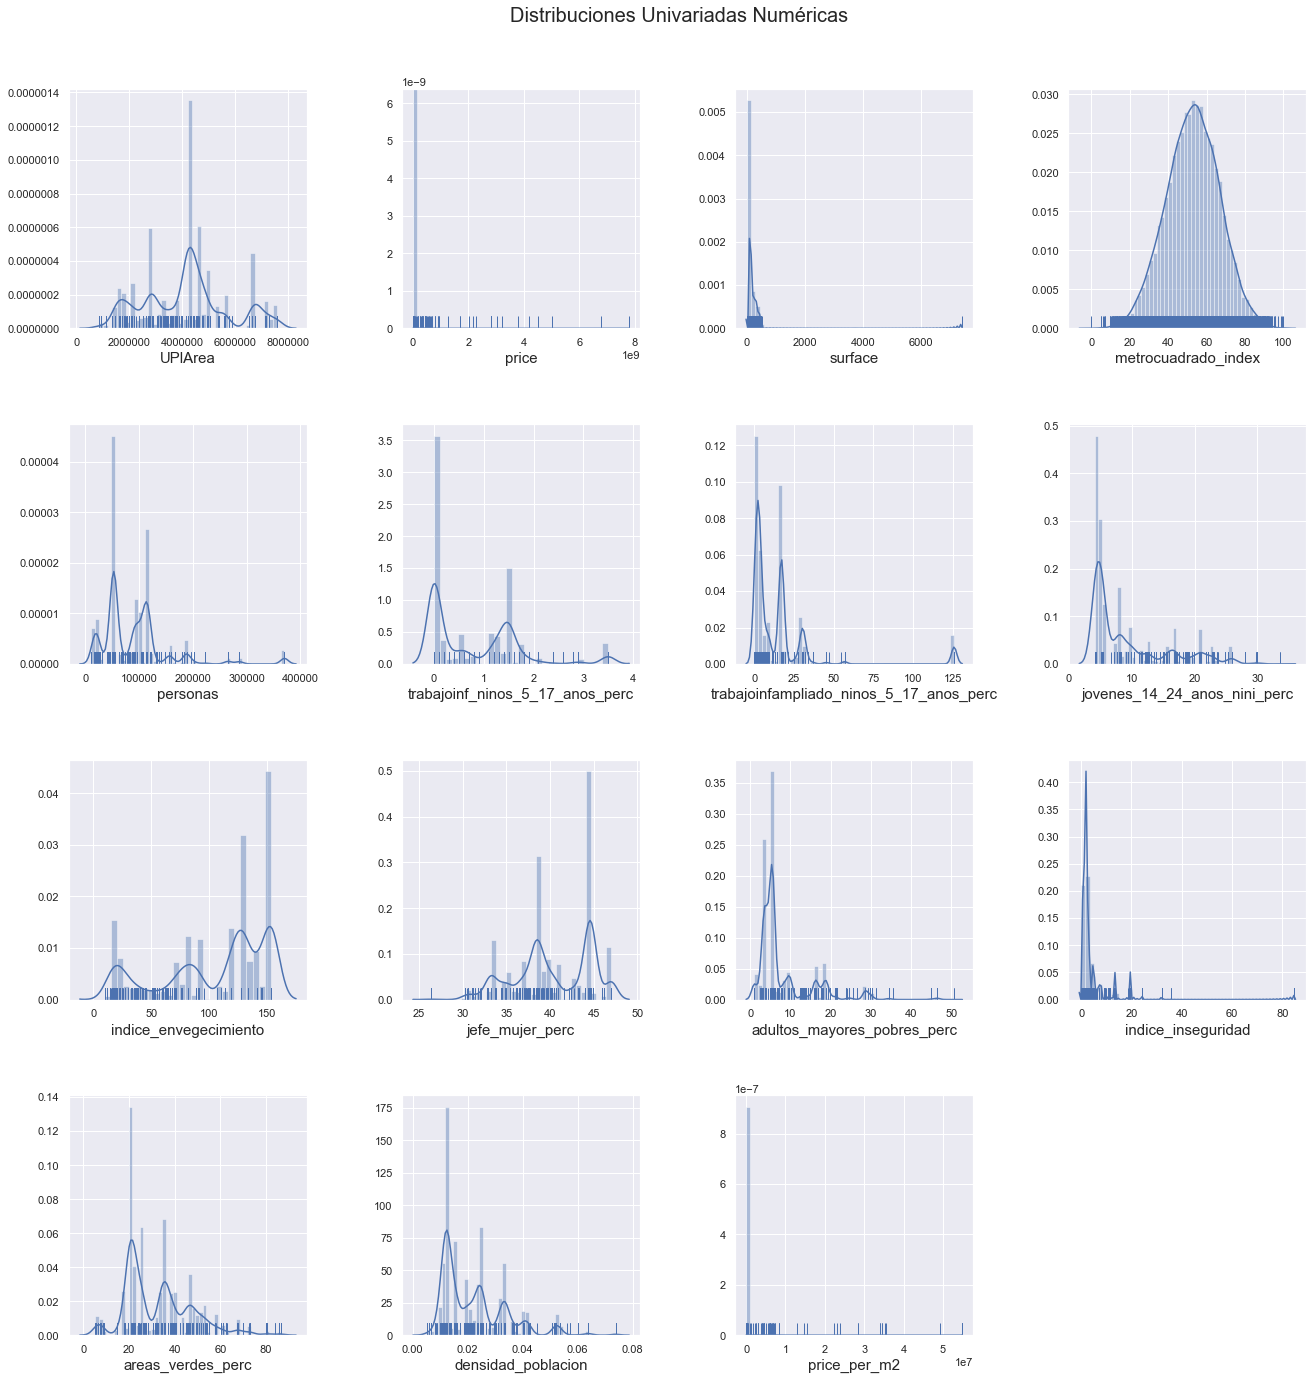

In [58]:
'''Se procede a graficar las distribuciones de las variables numéricas
'''
# Grilla de subplots
fig, ax = plt.subplots(nrows=4, ncols=4)#, figsize=[17, 17])

# Se remueven el ultimo plot
list(map(lambda a : a.remove(), ax[-1,-1:]))

# Se ajusta el espaciado exterior de la figura
fig.tight_layout()

# Se define un titulo y su ubicacion
fig.suptitle('Distribuciones Univariadas Numéricas',
             fontsize=20,
             x=0.5,
             y=1.05)
'''
Se recorre cada axis, para cada columna del dataframe, se genera un grafico 
distinto en funcion del tipo de dato.

'''
for axis, col in zip(ax.flatten(), numeric):
    try :
        # Graficos para datos numericos
        sns.distplot(df[('numeric', col)].dropna(), ax=axis, rug=True)
               
    except RuntimeError:
        sns.distplot(df[('numeric', col)].dropna(), ax=axis, rug=True, kde=False)
    
    axis.set_xlabel(col, fontsize=15)

# Se ajusta el espaciado interno entre subplots
w, h = (.4, .4)
plt.subplots_adjust(wspace=w, hspace=h)

In [59]:
'''Notamos en 'price' y 'price per_m2' que hay una diferencia muy brusca en la
densidad de los datos, donde la tendencia es clara a precios mas moderados en
comparacion.
Dado que 'price_per_m2' es nuestra variable respuesta, nos interesa que esta
presente una distribución que sea lo suficientemente suave para 
poder realizar futuras transformaciones en nuestro futuro modelo regresor.
Notamos que considerando datos con valor de 'price_per_m2' < 100.000, se 
obtiene el siguiente dataframe.
'''
df[df[('numeric','price_per_m2')]<=10**5]

numeric                                                  \
            UPlArea      price surface metrocuadrado_index personas   
0               NaN  1050000.0    63.0                25.6      NaN   
1               NaN   650000.0    36.0                32.5      NaN   
2               NaN   650000.0    36.0                31.8      NaN   
3               NaN  3930000.0   100.0                57.3      NaN   
4               NaN  1900000.0    97.0                38.7      NaN   
...             ...        ...     ...                 ...      ...   
16296           NaN   900000.0   100.0                34.9      NaN   
16297           NaN   950000.0   120.0                38.3      NaN   
16298           NaN   550000.0    40.0                31.4      NaN   
16299           NaN   630000.0    45.0                48.5      NaN   
16300  2.752775e+06   700000.0    30.0                31.5  68430.0   

                                                                               \
      trabajoinf_ninos_5_17_anos_perc trabajoinfampliado_ninos_5_17_anos_perc   
0                                 NaN                                     NaN   
1                                 NaN                                     NaN   
2                                 NaN                                     NaN   
3                                 NaN                                     NaN   
4                                 NaN                                     NaN   
...                               ...                                     ...   
16296                             NaN                                     NaN   
16297                             NaN                                     NaN   
16298                             NaN                                     NaN   
16299                             NaN                                     NaN   
16300                             0.6                                     3.9   

                                                                          ...  \
      jovenes_14_24_anos_nini_perc indice_envegecimiento jefe_mujer_perc  ...   
0                              NaN                   NaN             NaN  ...   
1                              NaN                   NaN             NaN  ...   
2                              NaN                   NaN             NaN  ...   
3                              NaN                   NaN             NaN  ...   
4                              NaN                   NaN             NaN  ...   
...                            ...                   ...             ...  ...   
16296                          NaN                   NaN             NaN  ...   
16297                          NaN                   NaN             NaN  ...   
16298                          NaN                   NaN             NaN  ...   
16299                          NaN                   NaN             NaN  ...   
16300                         20.7                  35.2       44.579934  ...   

        categorical                                               \
      property_type n_garajes n_rooms furnished rent_type n_bath   
0              casa         1       3       0.0  arriendo      2   
1       apartamento       NaN       1       0.0  arriendo      1   
2       apartamento       NaN       1       0.0  arriendo      1   
3              casa         1       3       1.0  arriendo      2   
4              casa         1       2       0.0  arriendo      3   
...             ...       ...     ...       ...       ...    ...   
16296          casa       NaN       1       0.0  arriendo    NaN   
16297          casa       NaN       1       0.0  arriendo    NaN   
16298   apartamento       NaN       1       0.0  arriendo      1   
16299   apartamento       NaN       1       0.0  arriendo      1   
16300   apartamento       NaN       1       0.0  arriendo      1   

                                     miscelaneous  \
                                         l

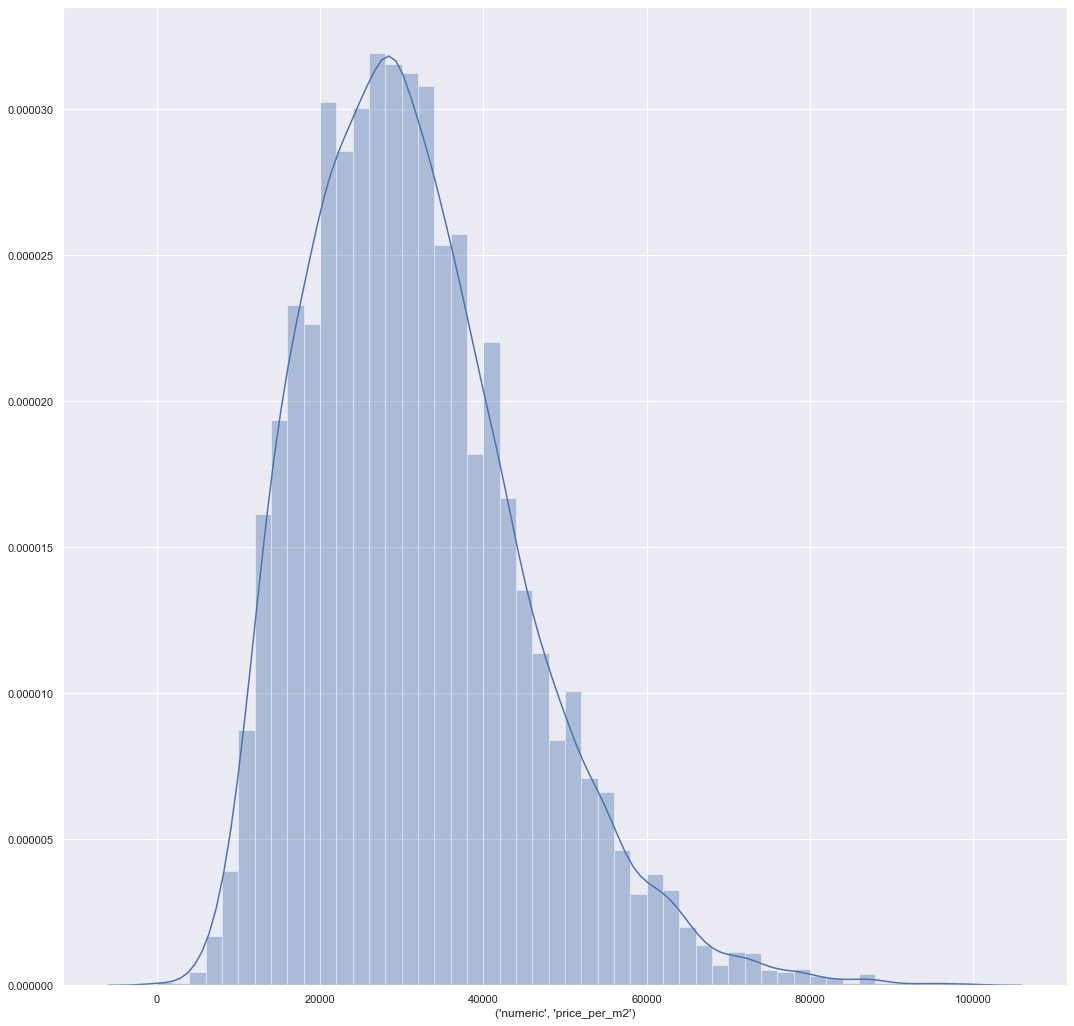

In [60]:
'''Tenemos una diferencia de 100 datos con la data original, es decir,
estamos ignorando los 100 valores donde 'price_per_m2' > 100.000. Veamos 
ahora como se ve su distribución.
'''
sns.distplot(df[df[('numeric','price_per_m2')] <= 10**5][('numeric','price_per_m2')])

In [61]:
'''Notamos una clara mejora con respecto al escenario con toda la data.
Actualizamos df y vemos ahora como distribuyen todas las variables numericas
asociadas.
'''
df = df[df[('numeric','price_per_m2')] <= 10**5]
df

numeric                                                  \
            UPlArea      price surface metrocuadrado_index personas   
0               NaN  1050000.0    63.0                25.6      NaN   
1               NaN   650000.0    36.0                32.5      NaN   
2               NaN   650000.0    36.0                31.8      NaN   
3               NaN  3930000.0   100.0                57.3      NaN   
4               NaN  1900000.0    97.0                38.7      NaN   
...             ...        ...     ...                 ...      ...   
16296           NaN   900000.0   100.0                34.9      NaN   
16297           NaN   950000.0   120.0                38.3      NaN   
16298           NaN   550000.0    40.0                31.4      NaN   
16299           NaN   630000.0    45.0                48.5      NaN   
16300  2.752775e+06   700000.0    30.0                31.5  68430.0   

                                                                               \
      trabajoinf_ninos_5_17_anos_perc trabajoinfampliado_ninos_5_17_anos_perc   
0                                 NaN                                     NaN   
1                                 NaN                                     NaN   
2                                 NaN                                     NaN   
3                                 NaN                                     NaN   
4                                 NaN                                     NaN   
...                               ...                                     ...   
16296                             NaN                                     NaN   
16297                             NaN                                     NaN   
16298                             NaN                                     NaN   
16299                             NaN                                     NaN   
16300                             0.6                                     3.9   

                                                                          ...  \
      jovenes_14_24_anos_nini_perc indice_envegecimiento jefe_mujer_perc  ...   
0                              NaN                   NaN             NaN  ...   
1                              NaN                   NaN             NaN  ...   
2                              NaN                   NaN             NaN  ...   
3                              NaN                   NaN             NaN  ...   
4                              NaN                   NaN             NaN  ...   
...                            ...                   ...             ...  ...   
16296                          NaN                   NaN             NaN  ...   
16297                          NaN                   NaN             NaN  ...   
16298                          NaN                   NaN             NaN  ...   
16299                          NaN                   NaN             NaN  ...   
16300                         20.7                  35.2       44.579934  ...   

        categorical                                               \
      property_type n_garajes n_rooms furnished rent_type n_bath   
0              casa         1       3       0.0  arriendo      2   
1       apartamento       NaN       1       0.0  arriendo      1   
2       apartamento       NaN       1       0.0  arriendo      1   
3              casa         1       3       1.0  arriendo      2   
4              casa         1       2       0.0  arriendo      3   
...             ...       ...     ...       ...       ...    ...   
16296          casa       NaN       1       0.0  arriendo    NaN   
16297          casa       NaN       1       0.0  arriendo    NaN   
16298   apartamento       NaN       1       0.0  arriendo      1   
16299   apartamento       NaN       1       0.0  arriendo      1   
16300   apartamento       NaN       1       0.0  arriendo      1   

                                     miscelaneous  \
                                         l

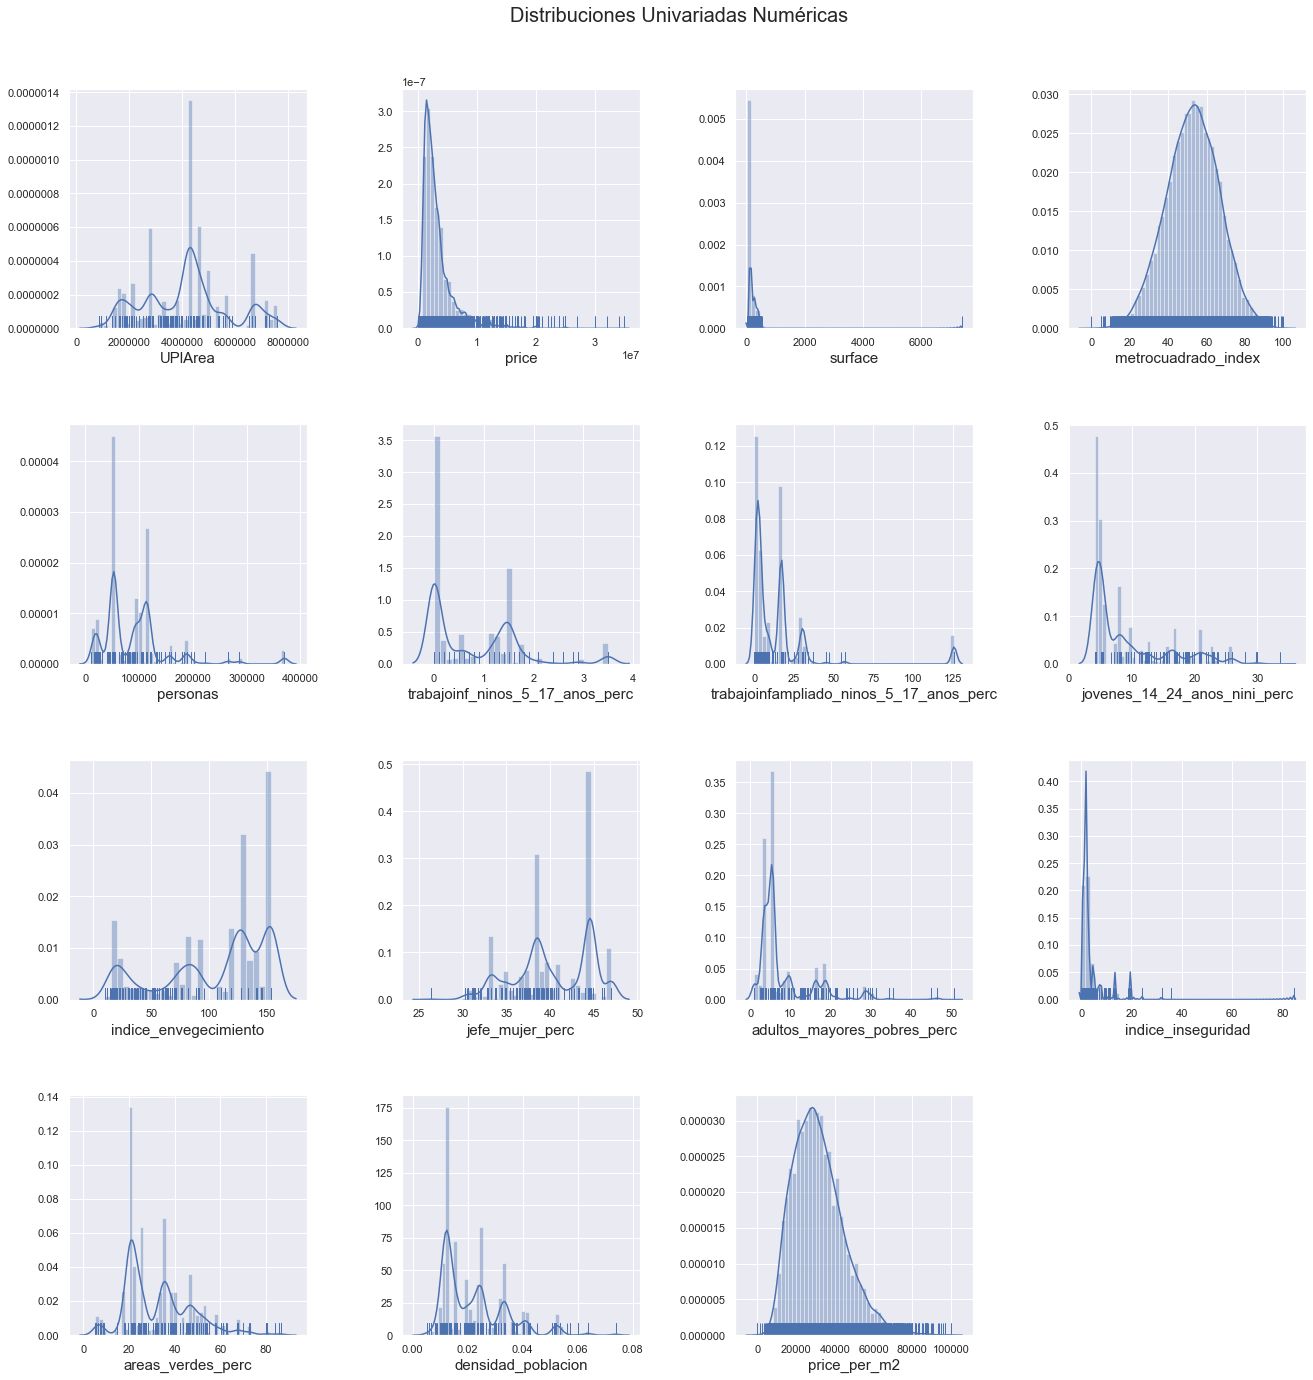

In [62]:
'''Se procede a graficar las distribuciones de las variables numéricas
luego del ajuste
'''
# Grilla de subplots
fig, ax = plt.subplots(nrows=4, ncols=4)#, figsize=[17, 17])

# Se remueven el ultimo plot
list(map(lambda a : a.remove(), ax[-1,-1:]))

# Se ajusta el espaciado exterior de la figura
fig.tight_layout()

# Se define un titulo y su ubicacion
fig.suptitle('Distribuciones Univariadas Numéricas',
             fontsize=20,
             x=0.5,
             y=1.05)
'''
Se recorre cada axis, para cada columna del dataframe, se genera un grafico 
distinto en funcion del tipo de dato.

'''
for axis, col in zip(ax.flatten(), numeric):
    try :
        # Graficos para datos numericos
        sns.distplot(df[('numeric', col)].dropna(), ax=axis, rug=True)
               
    except RuntimeError:
        sns.distplot(df[('numeric', col)].dropna(), ax=axis, rug=True, kde=False)
    
    axis.set_xlabel(col, fontsize=15)

# Se ajusta el espaciado interno entre subplots
w, h = (.4, .4)
plt.subplots_adjust(wspace=w, hspace=h)

In [63]:
'''Notamos como la distribución de la data es más clara al trabajar sin los casos
donde price_per_m2 es demasiado grande. Notamos en surface que existe un dato que se aleja
mucho de donde se concentra la data, y su valor es al menos superior a 1000, donde los 
demas valores se concentran por debajo de 1000. Buscamos tal valor
'''
df[('numeric','surface')].nlargest(2)

9491    7400.0
5318     540.0
Name: (numeric, surface), dtype: float64

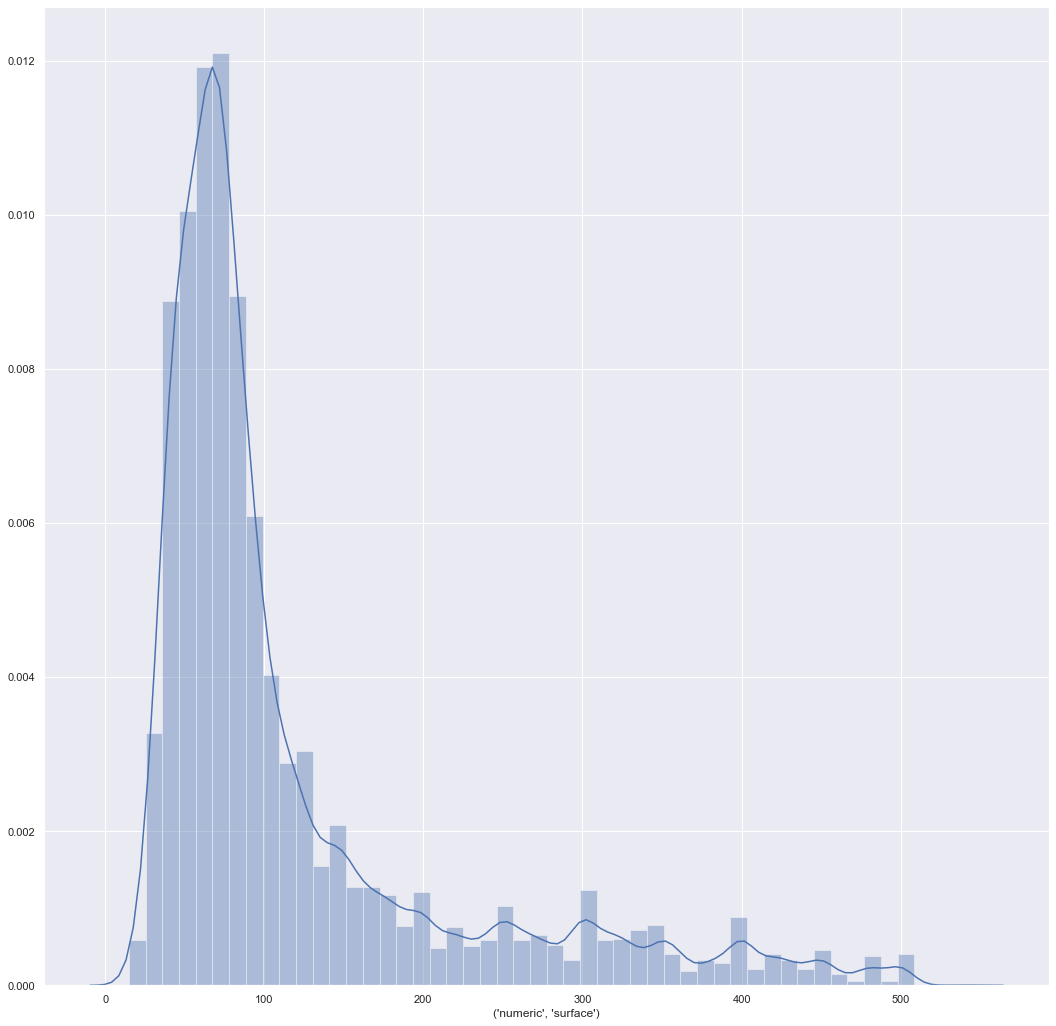

In [64]:
'''Veamos qué ocurre al quitar tal valor del dataframe, notamos una
clara mejora en la visualización.
'''
sns.distplot(df[df[('numeric','surface')]< 10**3][('numeric','surface')])

In [65]:
# Se actualiza df
df = df[df[('numeric','surface')]< 10**3]

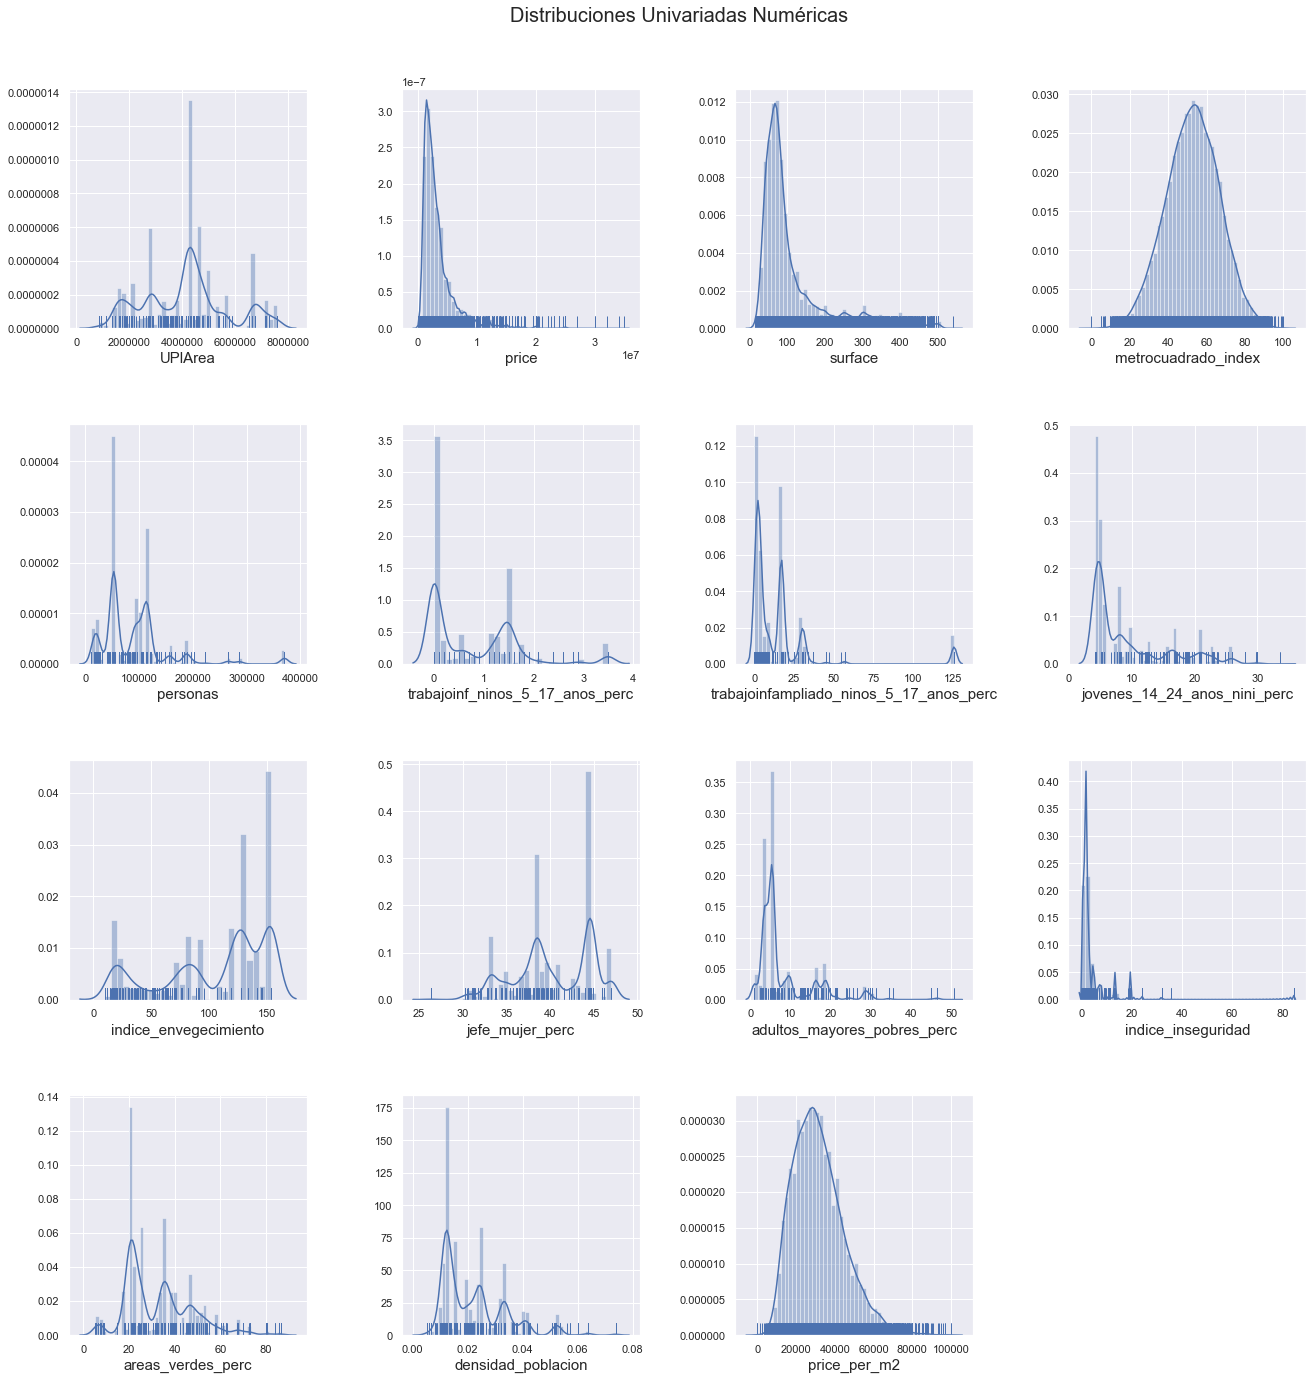

In [66]:
# Grilla de subplots
fig, ax = plt.subplots(nrows=4, ncols=4)#, figsize=[17, 17])

# Se remueven el ultimo plot
list(map(lambda a : a.remove(), ax[-1,-1:]))

# Se ajusta el espaciado exterior de la figura
fig.tight_layout()

# Se define un titulo y su ubicacion
fig.suptitle('Distribuciones Univariadas Numéricas',
             fontsize=20,
             x=0.5,
             y=1.05)
'''
Se recorre cada axis, para cada columna del dataframe, se genera un grafico 
distinto en funcion del tipo de dato.

'''
for axis, col in zip(ax.flatten(), numeric):
    try :
        # Graficos para datos numericos
        sns.distplot(df[('numeric', col)].dropna(), ax=axis, rug=True)
               
    except RuntimeError:
        sns.distplot(df[('numeric', col)].dropna(), ax=axis, rug=True, kde=False)
    
    axis.set_xlabel(col, fontsize=15)

# Se ajusta el espaciado interno entre subplots
w, h = (.4, .4)
plt.subplots_adjust(wspace=w, hspace=h)

In [67]:
'''Queremos ver como se comporta la variable 'price_per_m2' en respuesta
a algunas variables numéricas.
'''
def scatter_dists(col, df=df, h=.3, w=.1, fontdict={'fontsize': 20}, reg=True):
    ''' Recibe una columna numerica y genera una visualizacion comparativa.
    
    Genera una figura por sobre el dataframe (por defecto), recibe 
    parametros extra como el espaciado entre subfigura.
    
    Args:
    ----------
    
    col: String
         El nombre de la columna numerica a visualizar
    
    h,w: float
        Espaciado entre subplot h -> vertical, w -> horizontal
    
    fontdict: dict
             Permite configurar las fuentes de los subplots
    reg: bool
         Permite graficar una regresion lineal sobre los datos (if True)
        
    Returns: None
        Se muestra una figura en pantalla    
    
    '''

    # Estrucutra de figura y axes
    fig, ax = plt.subplots(2, 1, figsize=[12, 13])

    # violin plot --> equivalente a catplot(kind = 'violin')

    if reg:
        sns.regplot(x=df[('numeric', col)],
                    y=df[('numeric', 'price_per_m2')],
                    ax=ax[0])
        ax[0].set_title('Regplot plot {} vs price_per_m2'.format(col), fontdict)
    else:
        sns.scatterplot(('numeric', col),
                        y=('numeric', 'price_per_m2'),
                        data=df,
                        ax=ax[0])
        ax[0].set_title('Scatter plot {} vs price_per_m2'.format(col), fontdict)

    
    # Distribucion univariada
    sns.distplot(df[('numeric', col)].dropna(), ax=ax[1])

    ax[0].set_xlabel(col, fontdict)
    ax[1].set_xlabel(col, fontdict)

    ax[0].set_ylabel('price_per_m2', fontdict)
    ax[1].set_title('Frecuencias {}'.format(col), fontdict)

    plt.subplots_adjust(wspace=w, hspace=h)


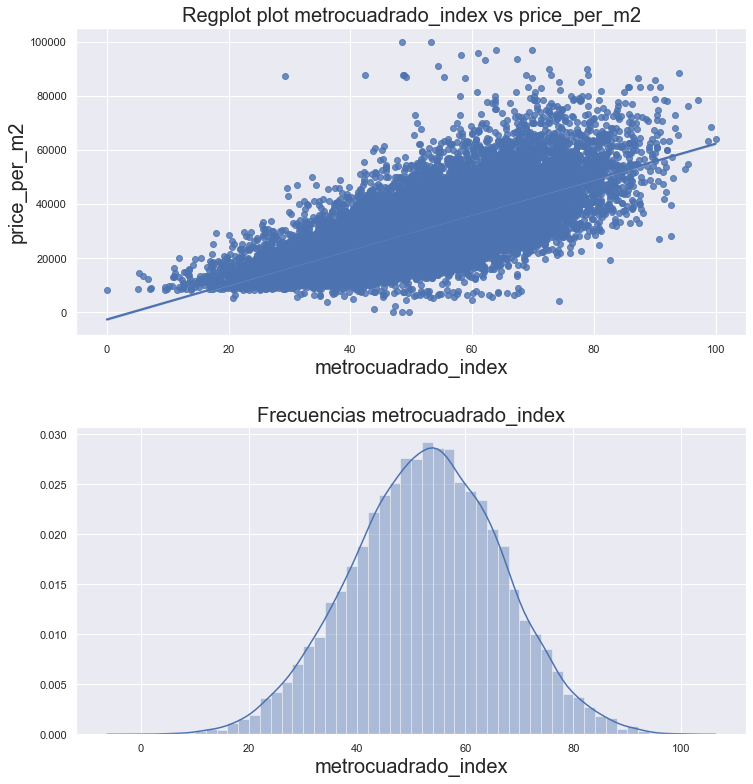

In [68]:
'''Notamos que la variable 'metrocuadrado_index', presenta una buena 
distribución en la data y presenta un comportamiento lineal con ruido, puede que esta 
variable sea de interés a la hora de regresionar 'price_per_m2'.
'''
scatter_dists('metrocuadrado_index')

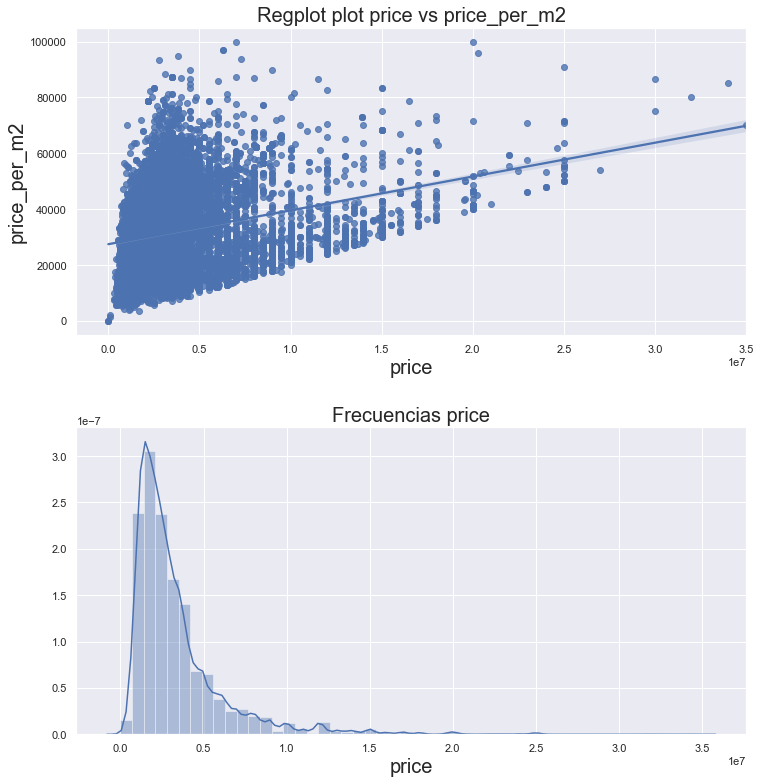

In [69]:
'''Notamos que las variables 'price' y 'surface' presentan un comportamiento
lineal con respecto a 'price_per_m2', pero esto se debe a como se generó la
columna 'price_per_m2', luego la relación existente entre éstas variables
fue impuesta y no presenta un caso de interés.
'''
scatter_dists('price')

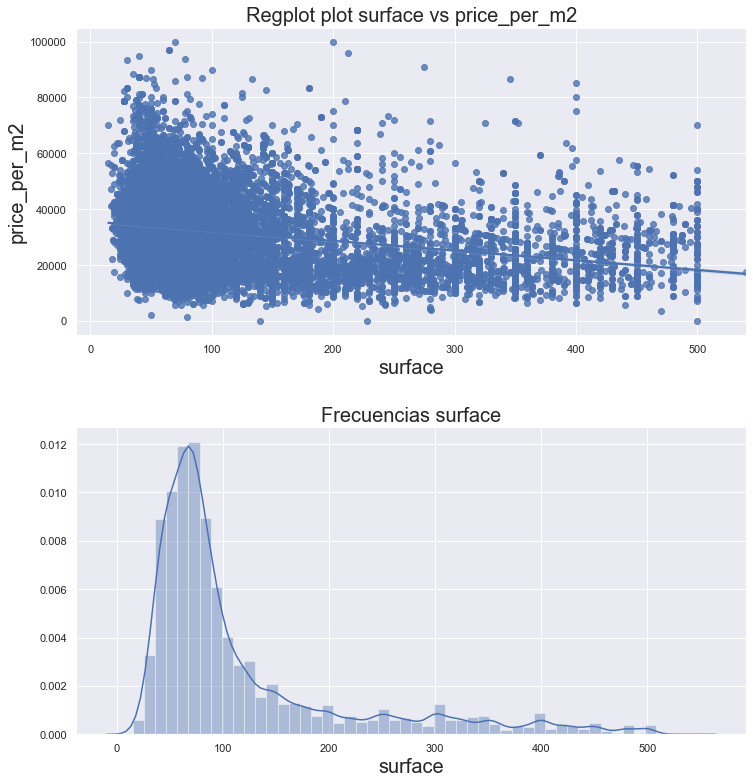

In [70]:
scatter_dists('surface')

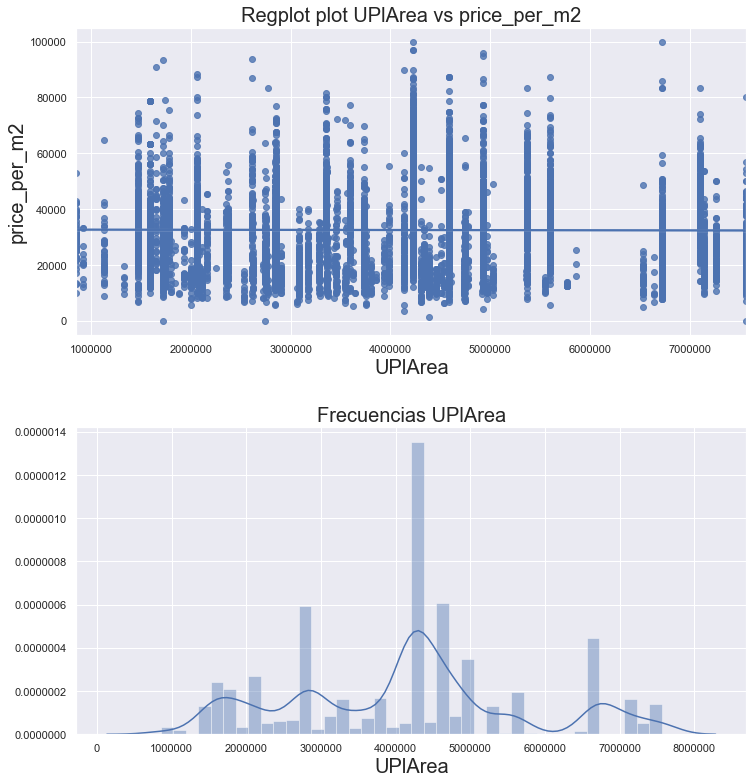

In [71]:
'''Ruido, 'price_per_m2' no presenta ninguna respuesta clara ante
esta variable. Su significancia deberá ser evaluada más adelante.

Resultado análogo entre
'UPlArea'
'trabajoinf_ninos_5_17_anos_perc'
'trabajoinfampliado_ninos_5_17_anos_perc'
'jovenes_14_24_anos_nini_perc'
'indice_envegecimiento'
'jefe_mujer_perc'
'adultos_mayores_pobres_perc'
'indice_inseguridad'
'areas_verdes_perc'
'densidad_poblacion'
'''
scatter_dists('UPlArea')

In [72]:
'''Variables categóricas
Procedemos a analizar las variables categóricas
'''
print(len(categorical))
print(categorical)

8
['upz', 'product_type', 'property_type', 'n_garajes', 'n_rooms', 'furnished', 'rent_type', 'n_bath']


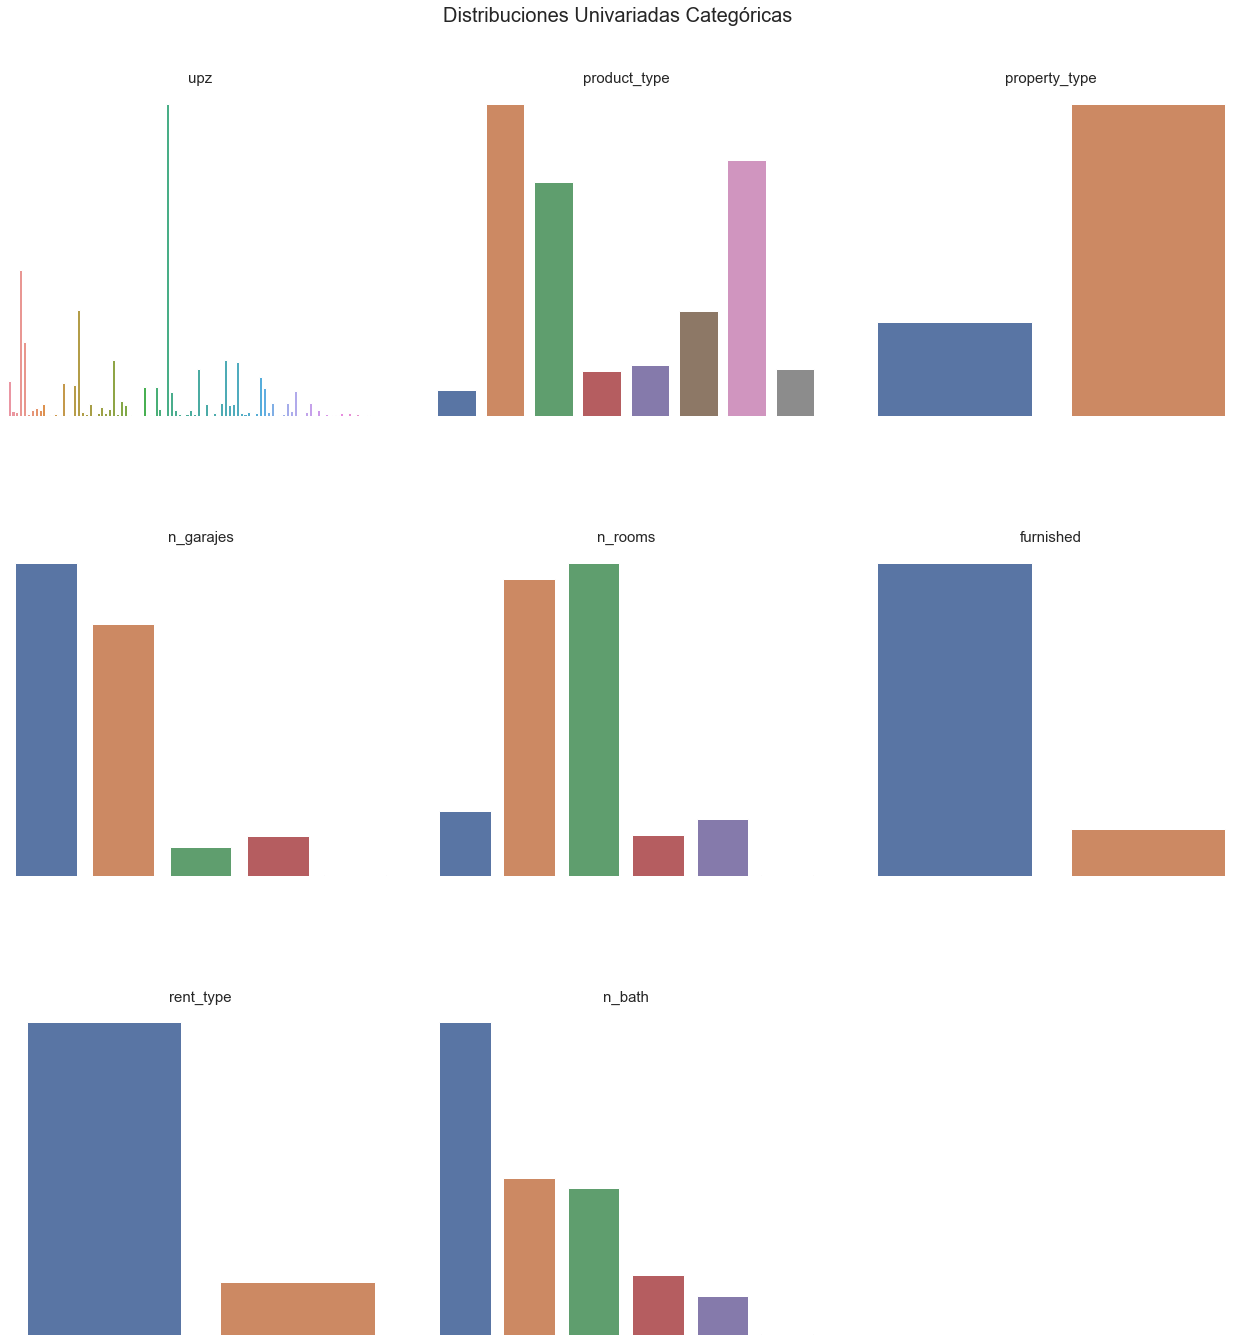

In [73]:
'''Se procede a graficar los histogramas de las variables categóricas
'''
# Grilla de subplots
fig, ax = plt.subplots(nrows=3, ncols=3)

# Se remueven el ultimo plot
list(map(lambda a : a.remove(), ax[-1,-1:]))

# Se ajusta el espaciado exterior de la figura
fig.tight_layout()
# Se define un titulo y su ubicacion
fig.suptitle('Distribuciones Univariadas Categóricas',
             fontsize=20,
             x=0.5,
             y=1.05)
'''
Se recorre cada axis, para cada columna del dataframe, se genera un grafico 
distinto en funcion del tipo de dato.

'''
for axis, col in zip(ax.flatten(), categorical):
    # Graficos para datos tipos str
    sns.countplot(df[('categorical',col)], ax=axis)
    axis.set_axis_off()
    axis.set_title(col, fontsize=15)
  
    
# Se ajusta el espaciado interno entre subplots
h, w = (.4, .1)
plt.subplots_adjust(wspace=w, hspace=h)

In [74]:
'''Estudiemos la variabilidad de las variables categóricas ''
'''
# Función para generar gráficos
def categoricalplot(col):
    # Sirve para fija el tamaño de las etiquetas del plot
    fontdict = {'fontsize':20}

    # Estrucutra de figura y axes
    fig, ax = plt.subplots(2,1,figsize=[12,13])
    
    # violin plot --> equivalente a catplot(kind = 'violin')

    sns.violinplot(('categorical', col),
                y=('numeric', 'price_per_m2'),
                data=df,
                kind='violin',
                ax=ax[0])

    sns.countplot(df[('categorical',col)], ax=ax[1])

    ax[0].set_xlabel(col, fontdict)
    ax[1].set_xlabel(col, fontdict)

    ax[0].set_ylabel('precio_per_m2', fontdict)
    ax[0].set_title('Violin plot {} vs price_per_m2'.format(col), fontdict)
    ax[1].set_title('Frecuencias {}'.format(col), fontdict)

    h, w = (.3, .1)
    plt.subplots_adjust(wspace=w, hspace=h)

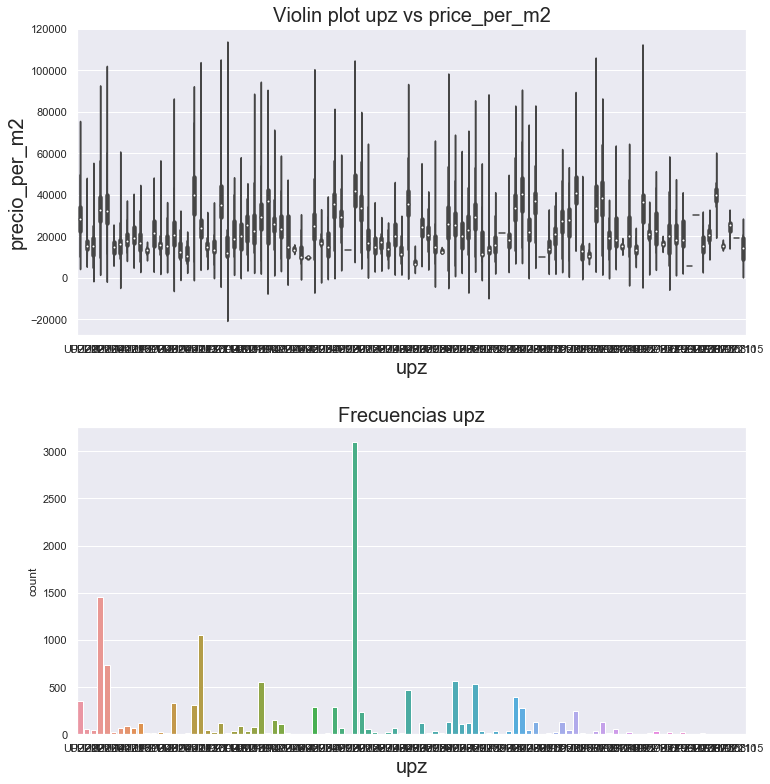

In [75]:
'''upz
Observamos que la variable categoriza upz presenta un histograma a la vista
confuso(demasiadas categorias), por lo que más adelante buscaremos una mejor
manera de agrupar éstas categorías.
'''
categoricalplot('upz')

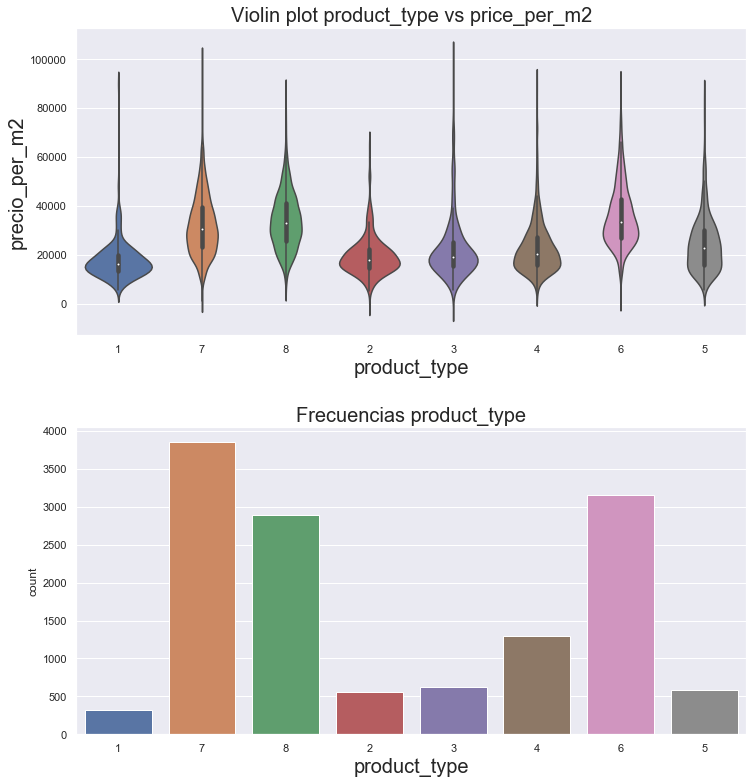

In [76]:
'''product_type
Notamos que para los 'product_type' 1-5 (casas), presentan una
concentración en valores levemente más bajos que los 6-8 (apartamentos), además
la variabilidad del valor de precio dado si es casa o apartamento presentan una
distribución similar. Por ende product_type podría corresponder a una variable
de interés a la hora de definir 'price_per_m2'.
'''
categoricalplot('product_type')

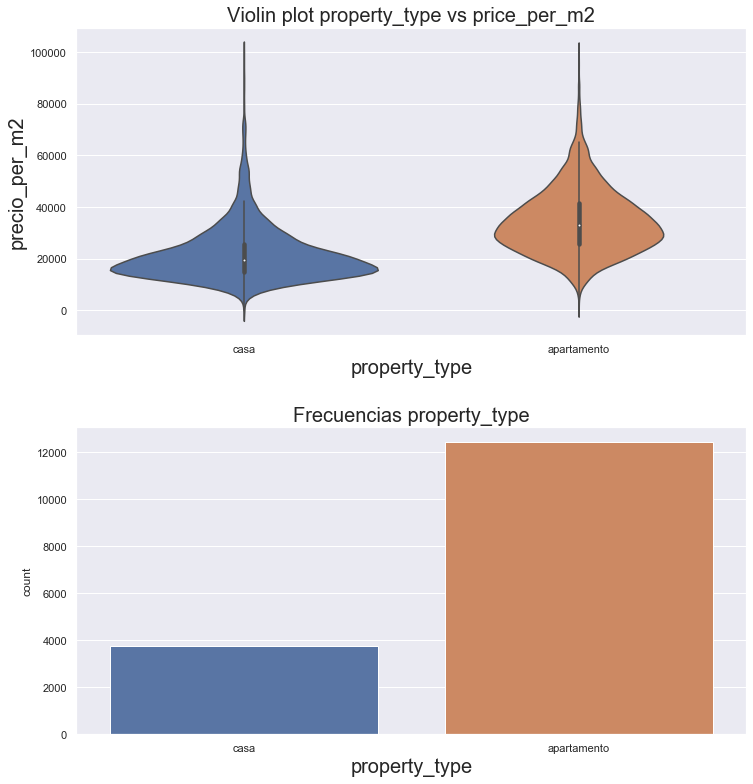

In [77]:
'''property_type
Notamos que los valores de 'precio_per_m2'para la categoría 'casa' se concentran
en su mayoría en un valor menor que la categoría apartamento. Ésto se condice
con el gráfico anterior y se debe en parte a cómo definimos la variable
'product_type', luego existe cierta correlación entre éstas dos variables,
lo cual puede corroborarse mediante un test estadístico.
'''
categoricalplot('property_type')

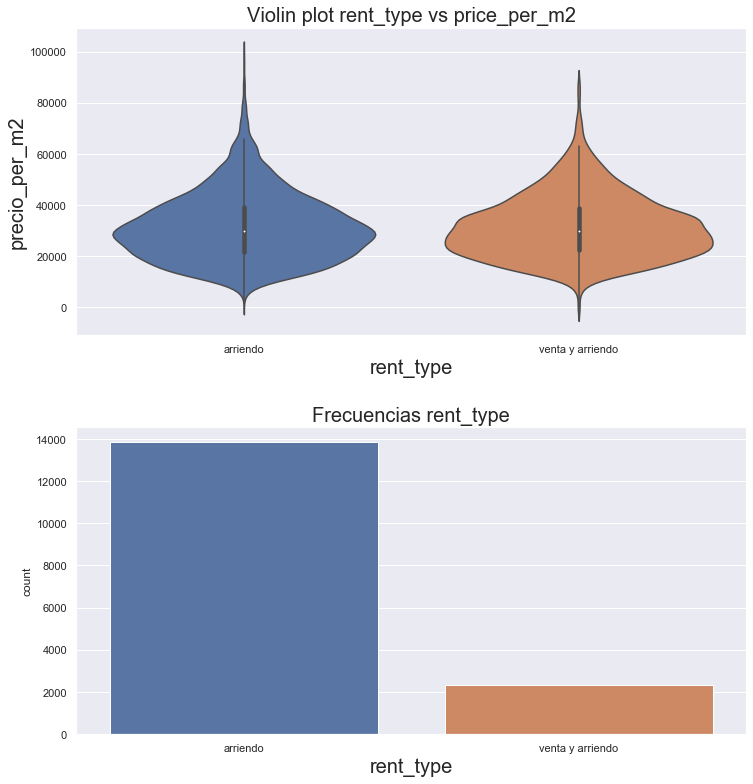

In [78]:
'''rent_type
Notamos que no difieren en mediana y sus distribuciones en 'price_per_m2'
se comportan de manera similar, por ende no existe una manera de poder
identificar una de las categorías en base al valor de 'price_per_m2'.
Por lo tanto, 'rent_type' corresponde a una variable candidata a no ser 
considerada en el modelo final.
'''
categoricalplot('rent_type')

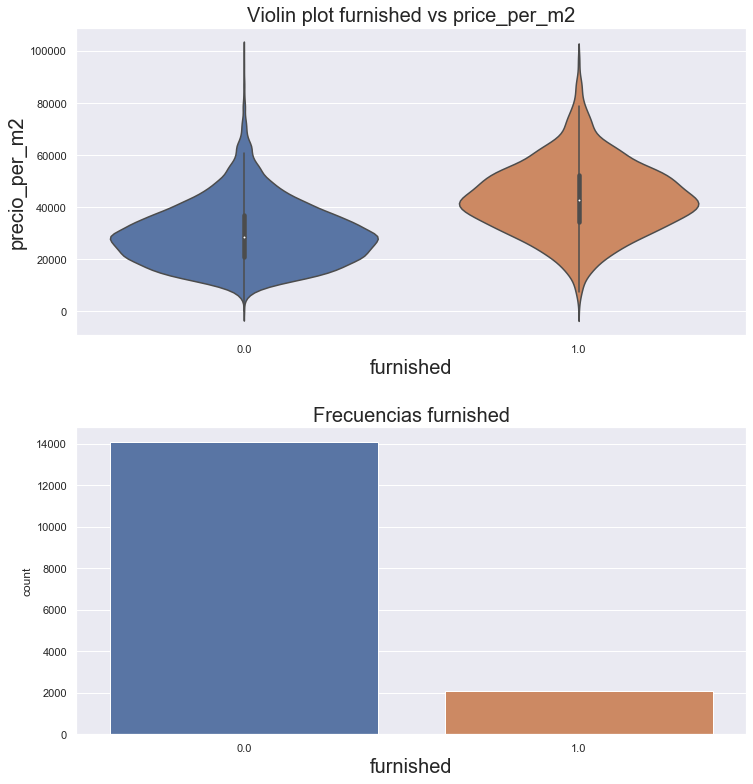

In [79]:
'''furnished
Si bien no se nota una diferencia en los valores donde más se cocentra
cada categoría, el hecho de la clara diferencia en la distribución de
la variable nos hace dudar sobre la efectividad en describir la variable
'price_per_m2', en caso de ser incluída en el modelo. Por lo tanto,
más adelante se verá si incluir o no esta variable en el modelo final.
'''
categoricalplot('furnished')

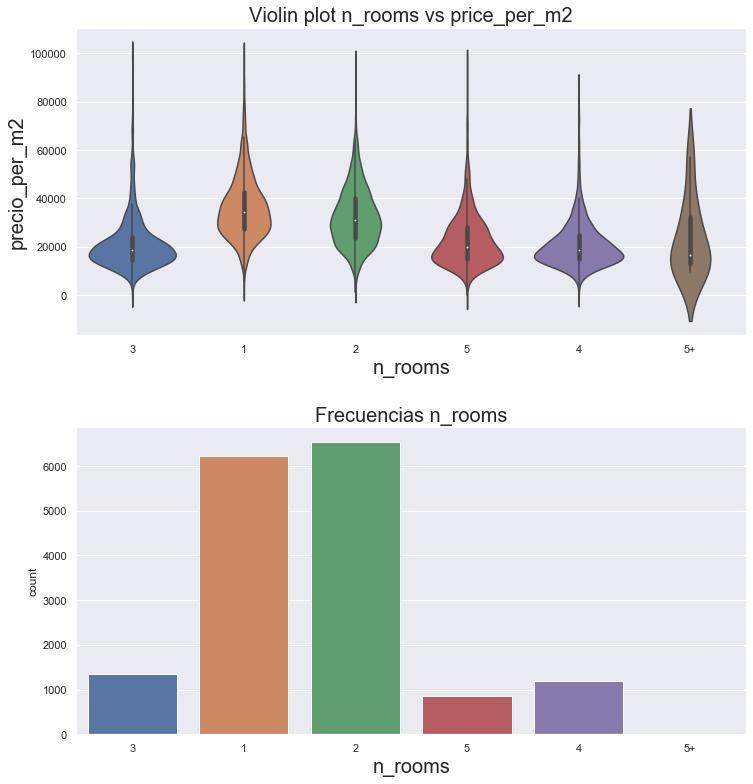

In [80]:
'''n_rooms
Se notan claras diferencias en las medias del valor 'price_per_m2'
entre categorias, ademas de una distribución normalmente aproximable
en los valores en esta variable. Por lo tanto corresponde a un candidato
sólido a ser incluido en el modelo final.
'''
categoricalplot('n_rooms')

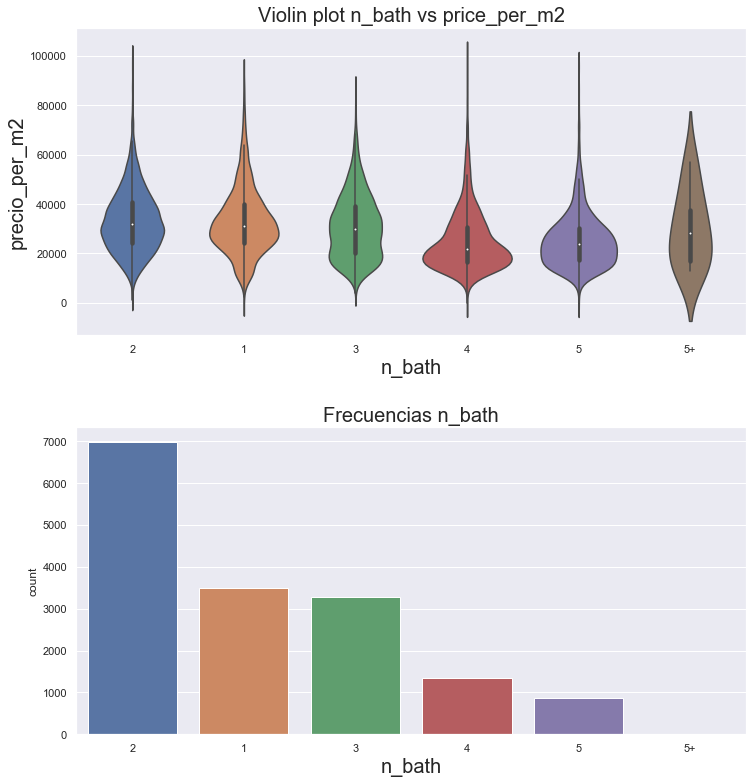

In [81]:
'''n_bath
Si bien la diferencia de medias en este caso tambien existe pero en menor
medida, la forma variabilidad en su distribución puede ser información 
valiosa para la descripción de 'price_per_m2', por lo tanto a priori es 
una variable interesante a considerar.
'''
categoricalplot('n_bath')

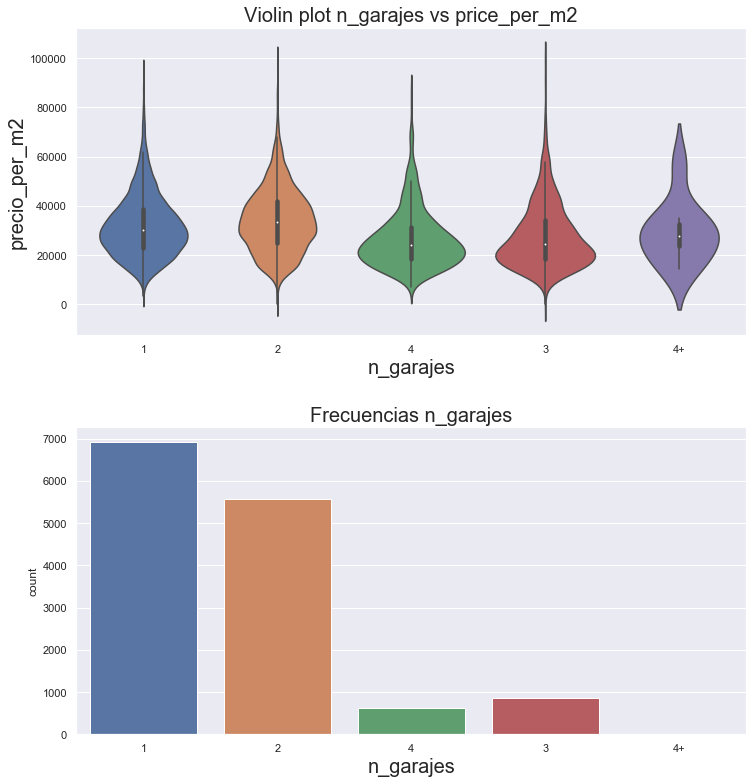

In [82]:
'''n_garajes
Tenemos un caso similar a 'n_rooms', donde aquí la diferencia de medias
es menos clara, y debido a que los violines son más achatados nos hace
dudar sobre la correcta descripción de 'price_per_m2' por medio de esta
variable. Veremos mediante un test one-way-ANOVA si existe una diferencia
significativa entre grupos.
'''
categoricalplot('n_garajes')

In [83]:
'''Se genera una función auxiliar para indexar las columnas en base
a su tipo, extraído de la clase 9 del curso.
'''
def indexer(cols, t_c = df.columns):
    '''Genera columnas multinivel a partir de nombres de columna planos.'''
    
    set_to_tuple = set(*[cols])

    tuples = [
        i for i in t_c if set_to_tuple.intersection(set(i))
    ]
    
    return tuples

In [84]:
idx = indexer(['price_per_m2','n_garajes'])
grouped = df[idx].groupby(idx[1])
total_groups = grouped.groups.keys()
groups = [grouped.get_group(i) for i in total_groups]
groups[0]

,numeric,categorical
,price_per_m2,n_garajes
0,16666.666667,1
3,39300.000000,1
4,19587.628866,1
5,28787.878788,1
6,23913.043478,1
...,...,...
16284,10000.000000,1
16286,12500.000000,1
16287,9375.000000,1


In [85]:
'''Se utiliza una función auxiliar para limpiar el formato de cada grupo,
extraído de la clase 9 del curso.
'''
def group_cleaner(group):
    ''' Limpia un grupo.
    Reconoce la categoria del grupo, en la posicion [:,1], 
    guarda ese nombre y elimina la columna de categoria, 
    posteriormente renombra la columna.
    
    Args:
    ----------
    
    group: pandas Groupby object
          Recibe una agrupacion para categorias
          
    Returns:
    ----------
        pandas Grppuby object
        Entrega el grupo ordenado.
    '''
    group_0 = group.copy()
    name = group_0.iloc[0,1]
    group_0.drop(indexer(['n_garajes']), axis=1, inplace=True)
    group_0.columns  = ('cat_{}'.format(name),)
    
    return group_0

In [86]:
'''Se procede a limpiar el formato de cada grupo y se realiza el test
'''
groups_to_test = list(map(group_cleaner, groups))

from scipy.stats import f_oneway

F,p = f_oneway(*groups_to_test)

print('Estadistico F:',F)
print('p valor :', p)

Estadistico F: [90.81990125]
p valor : [2.3514614e-76]


In [87]:
'''Con esto, rechazamos la nula: 'No hay diferencia significativa entre
grupos'. Por lo tanto, 'n_garajes' corresponde a una variable de interés
a analizar.
'''
alpha = 0.05
p <= alpha

array([ True])

## Parte 3

In [88]:
'''Para ver las variables faltantes, recuperamos df_copy previo a las
modificaciones hechas en P2.2
'''
df_copy.isnull().sum()

numeric       UPlArea                                    1946
              price                                         0
              surface                                      16
              metrocuadrado_index                           0
              personas                                   1946
              trabajoinf_ninos_5_17_anos_perc            1946
              trabajoinfampliado_ninos_5_17_anos_perc    1946
              jovenes_14_24_anos_nini_perc               1946
              indice_envegecimiento                      1946
              jefe_mujer_perc                            1946
              adultos_mayores_pobres_perc                1946
              indice_inseguridad                         1946
              areas_verdes_perc                          1946
              densidad_poblacion                         1946
              price_per_m2                                 16
categorical   upz                                        1946
        

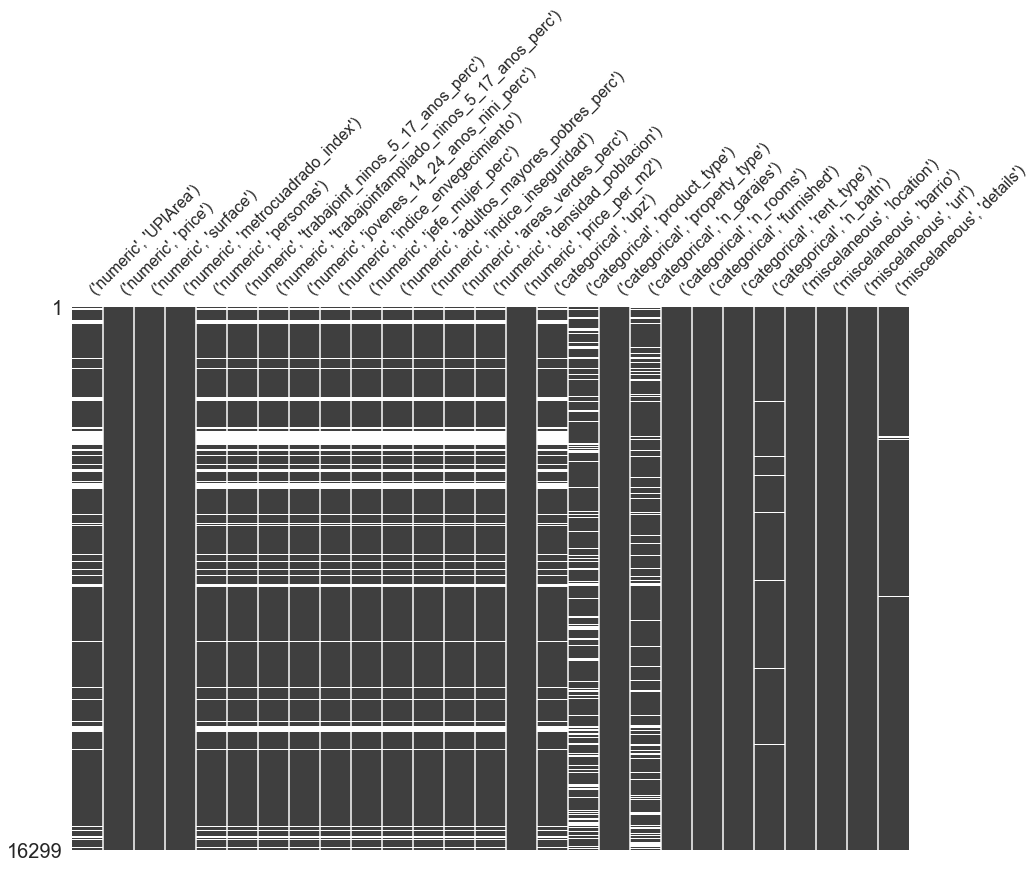

In [89]:
'''Vemos un esquema general de los valores faltantes en de la data,
se puede observar un comportamiento similar en la ausencia de los 
datos asociados a las estadísticas incluidas mediante un cruce con los
códigos upz. Ésto claramente es debido a que al existir barrios donde no 
fue posible obtener identificación mediante el código upz, no fue posible
cruzar las estadísticas en la sección P1.6, por lo tanto la ausencia
de las estadísticas se refleja en la ausencia de upz. El tratamiento
para estos datos faltantes será eliminarlos, pues debido a no poder
recuperar el upz, no podremos recuperar de manera consistente las
estadísticas.
'''
fig, ax = plt.subplots(figsize = [15, 10])
msno.matrix(df_copy,ax = ax, sparkline=False)

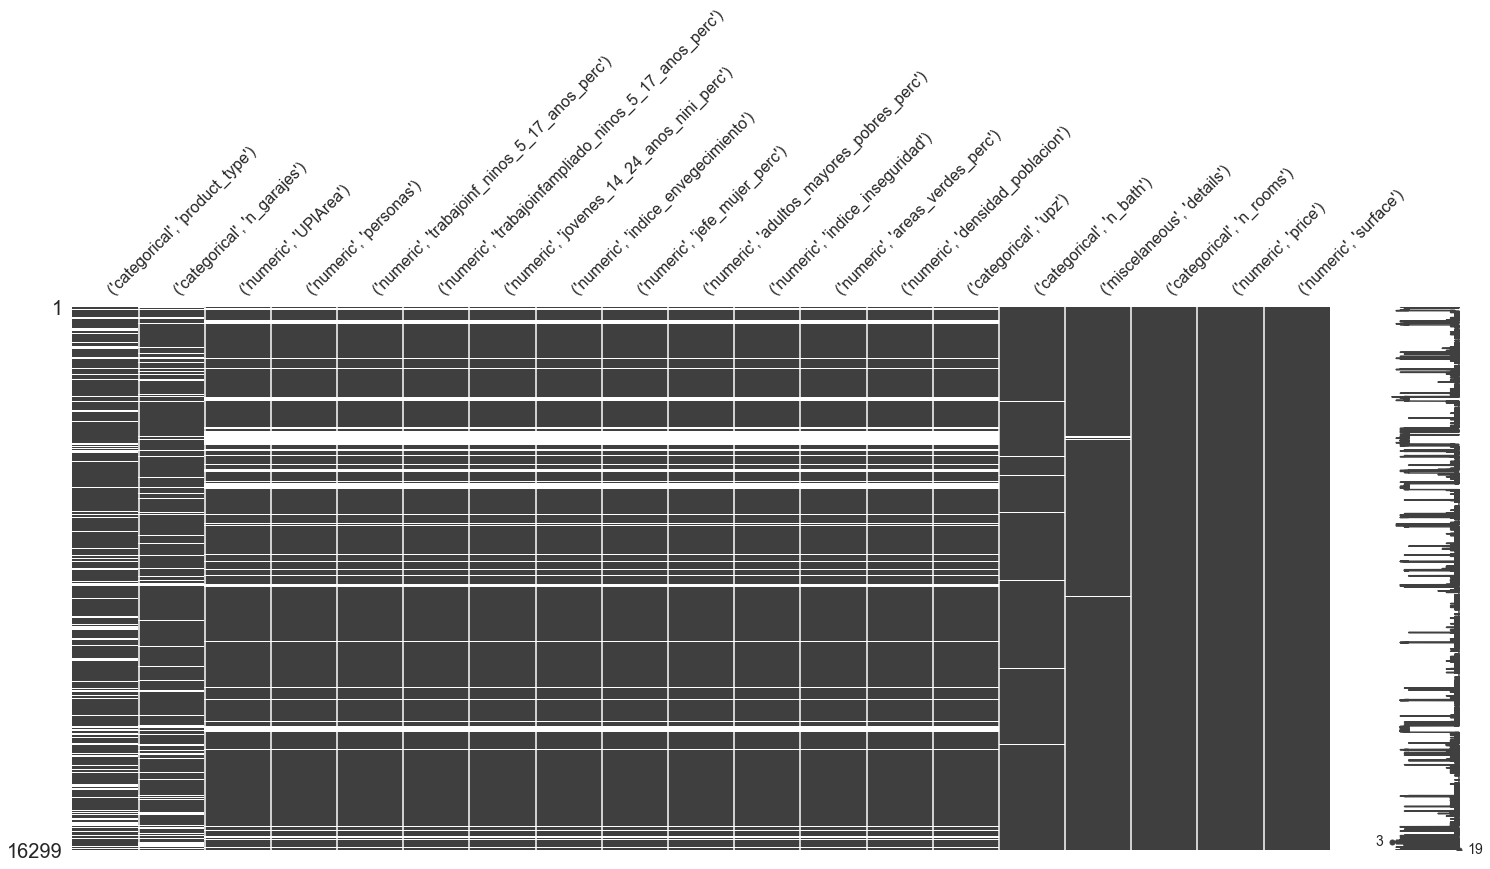

In [90]:
'''Esquema ordenado según cantidad de datos faltantes
Observamos que las columnas con más datos faltantes correspondes a
`product_type` y 'n_garajes'
-'product_type' se debe a como la definimos en 
la sección P1.4, luego depende de parámetros visibles en la data
('property_type','rent_type','surface'). Nuestro tratamiento para ésta 
variable será simplemente eliminarlas.
-'n_garajes' se debe a la ausencia de la keyword '-garajes' en url. Por
lo tanto, la ausencia de ésta data se puede inferir a partir de la 
variable 'url', variable sobre la cual fue construida esta columna.

Respecto a las columnas 'n_bath','details','n_rooms','price','surface'
no es posible determinar un patron claro, más aun cuando la ausencia
de las variables en las ultimas 3 mencionadas son pocas (menos de 33).
Creemos entonces que ésta información es perdida completamente al azar,
pues depende de algo que no estamos viendo reflejado en la data(mal 
ingreso de los datos, omisión de informacion por parte del vendedor,etc.)
Ésta información se intentará imputar asignando media mediante agrupaciónes
por 'upz' donde sea posible.
'''
msno.matrix(df_copy[list(df.isnull().sum().nlargest(19).index)], sparkline=True)

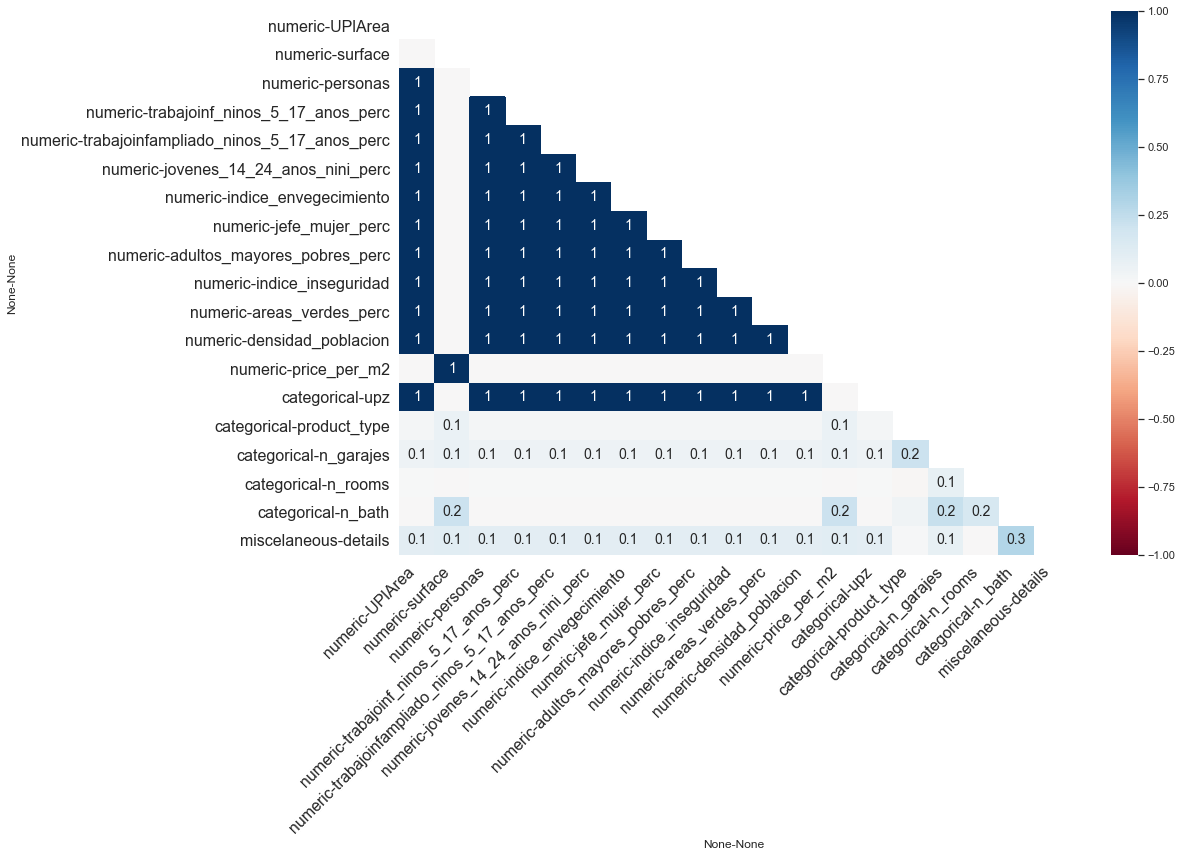

In [91]:
'''Mediante un mapa de calor podemos identificar la correlación
entre los valores faltantes, para determinar si existe algún tipo
de dependencia en la ausencia de éstos datos.
En efecto, notamos como las variables asociadas a las estadísticas
incluidas en la sección P1.6 presentan correlación 1 entre ellas y 
con upz, confirmando entonces la clara dependencia de la ausencia de 
estos datos en base a la ausencia de upz. 
Además, notamos una trivial correlación de 1 entre surface y 
price_per_m2 debido a que la data faltante(surface=0) genera una
imposibilidad en el cálculo de price_per_m2(sería infinito).
'''
fig, ax = plt.subplots(figsize = [15, 10])
msno.heatmap(df_copy, ax = ax)

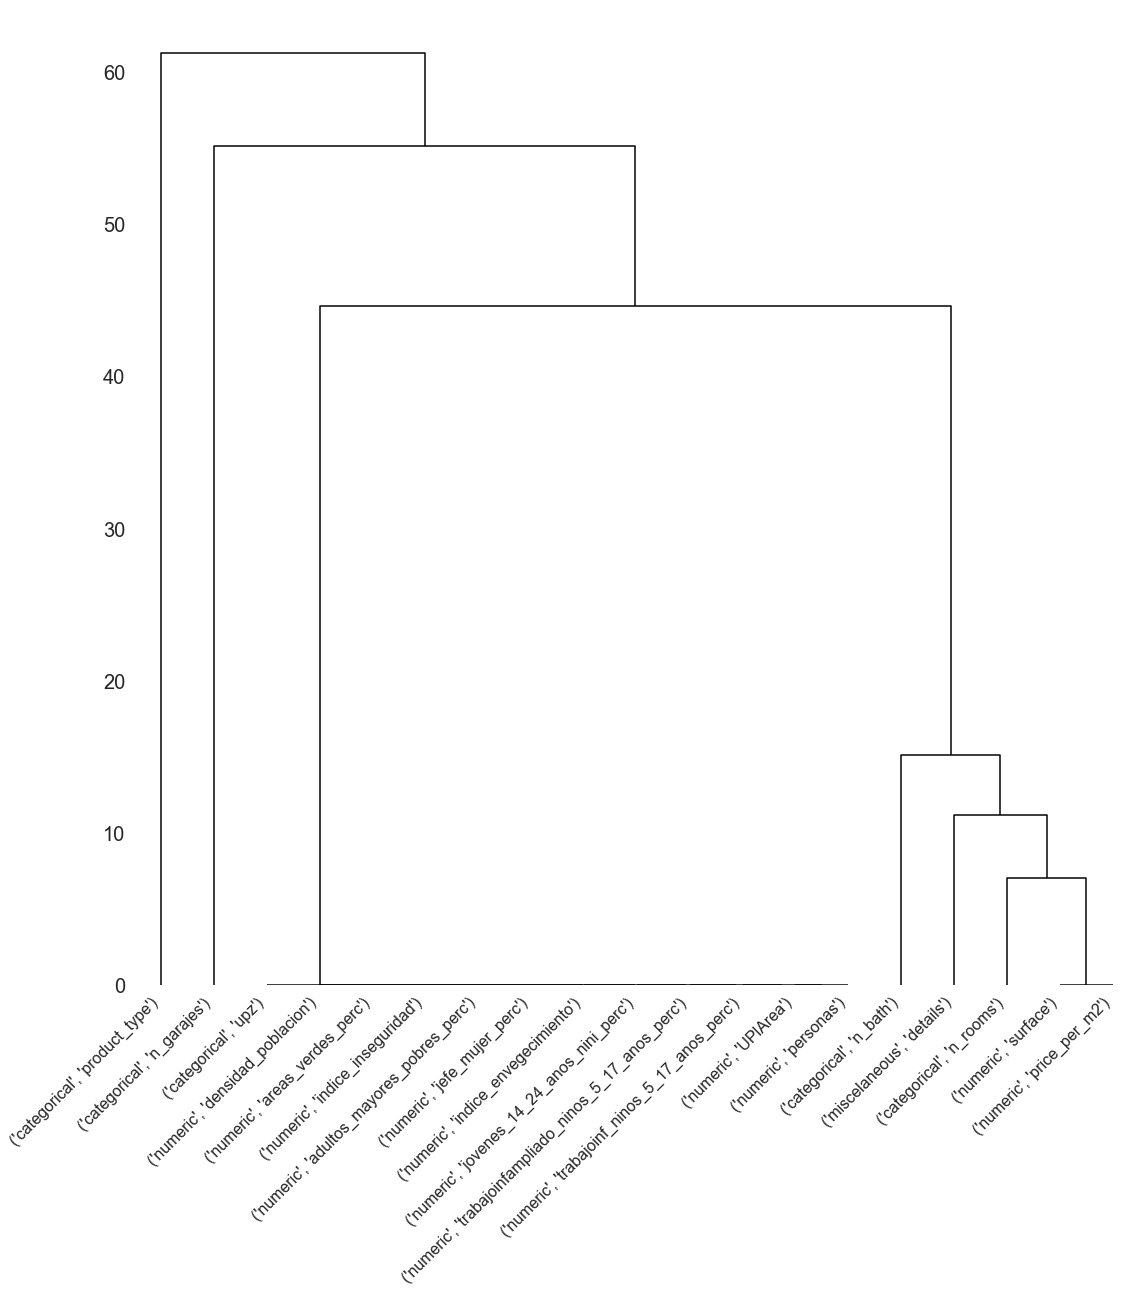

In [92]:
'''A través de un dendograma podemos confirmar la relación de datos 
faltantes, ahora entre grupos. Confirmamos lo mencionado con las 
estadísticas y upz, junto con la relacion 'surface' y 'price_per_m2'.

Se observa cómo 'product_type' no tiene relación alguna en su
ausencia de datos con variables como 'property_type','rent_type',
'surface', sino mas bien en los rangos de valor de éstas. 

Además notamos que la ausencia de datos en 'n_garajes' tambien es ajena
a la ausencia de datos en otras variables expuestas acá.

Concluimos entonces que las variables 'price_per_m2' y 'property_type'
presentan un tipo de mecanismo de pérdida de información del tipo MAR,
pues su ausencia depende de variables que podemos observar su valor:
- 'surface' para 'price_per_m2'
- 'property_type','rent_type','surface' para 'product_type'

Por otro lado, las estadísticas cumplen la hipótesis MNAR, ya que la ausencia de información
en estas variables se explica por la variable ausente 'upz'.
'''
fig, ax = plt.subplots()
msno.dendrogram(df_copy[list(df_copy.isnull().sum().nlargest(19).index)], ax=ax,orientation='top')

## Parte 4

In [93]:
'''Recordemos como distribuye la variable categorica 'upz'
'''
UPZs = df[[('categorical','upz'),('numeric','price_per_m2')]]
UPZs

,categorical,numeric
,upz,price_per_m2
0,NaN,16666.666667
1,NaN,18055.555556
2,NaN,18055.555556
3,NaN,39300.000000
4,NaN,19587.628866
...,...,...
16296,NaN,9000.000000
16297,NaN,7916.666667
16298,NaN,13750.000000


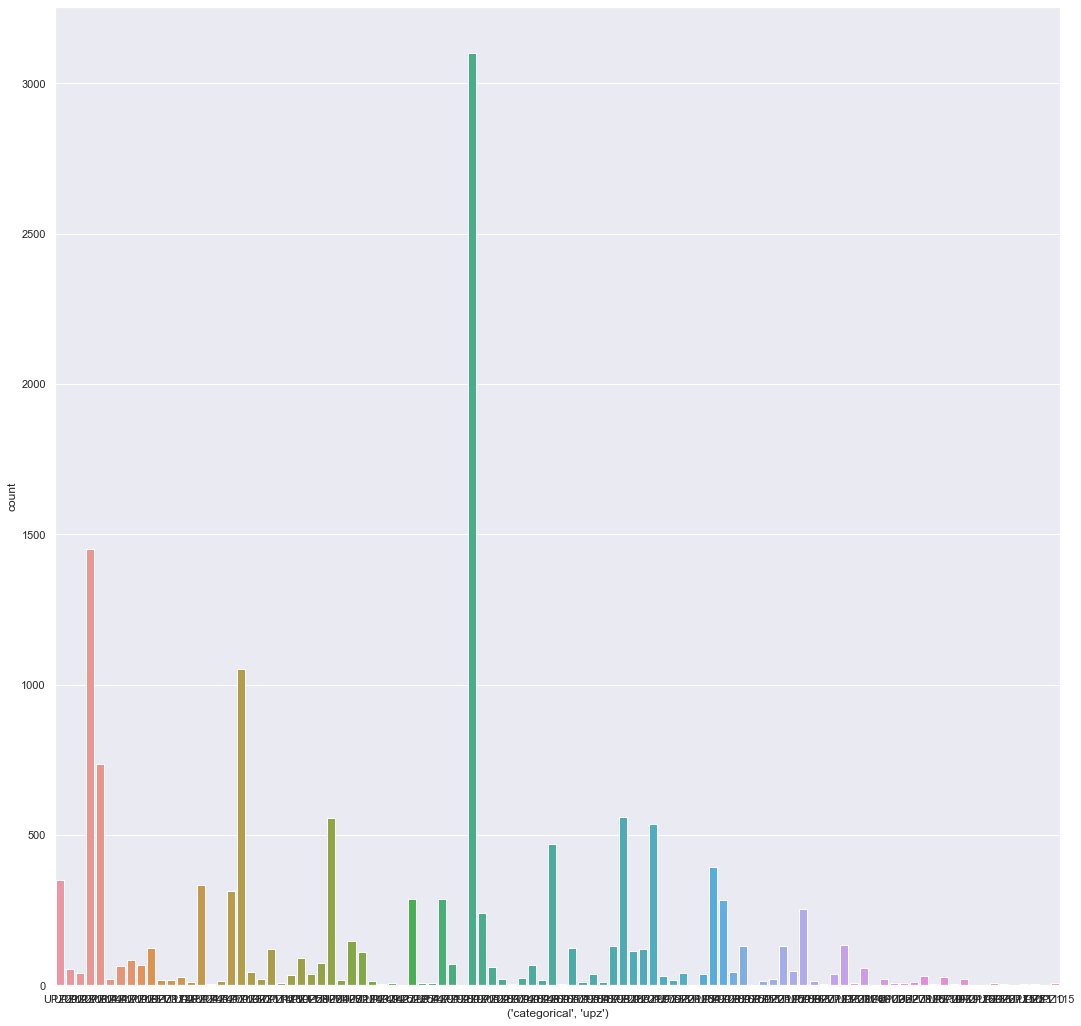

In [94]:
sns.countplot(UPZs[('categorical','upz')])

In [95]:
#df[df[('categorical','upz')].isnull()]

In [96]:
#data =  UPZs[('categorical','upz')].copy()
#data

In [97]:
#X = data.dropna().unique().reshape(-1,1)
#X[:10]

In [98]:
#from sklearn.preprocessing import OrdinalEncoder
#enc = OrdinalEncoder()

In [99]:
#enc.fit_transform(X)

In [100]:
#from sklearn.preprocessing import OneHotEncoder
#encoder=OneHotEncoder(sparse=False)

In [101]:
#encoder.fit_transform(X)

In [102]:
#grouped_df = df.groupby(by=('categorical','upz')).mean()[('numeric','price_per_m2')]
#grouped_df

In [103]:
#grouped_df.index.str.strip('UPZ')

In [104]:
#df[('categorical','upz')]

In [105]:
#X = grouped_df.values.reshape(-1,1)
#X

In [106]:
#from sklearn.cluster import KMeans

In [107]:
#clusters = KMeans(n_clusters = 5) 

In [108]:
#clusters.fit_transform(X)

## Parte 5

In [109]:
'''Veamos ahora si existe dependencia entre variables de interés
'''
interest = ['price','surface','metrocuadrado_index','personas',
            'indice_inseguridad','price_per_m2',
            'n_rooms','n_garajes','n_bath']
idxs = indexer(interest)
idxs.sort()
idxs.remove(('numeric', 'price_per_m2'))
idxs.append(('numeric', 'price_per_m2'))
idxs

[('categorical', 'n_bath'),
 ('categorical', 'n_garajes'),
 ('categorical', 'n_rooms'),
 ('numeric', 'indice_inseguridad'),
 ('numeric', 'metrocuadrado_index'),
 ('numeric', 'personas'),
 ('numeric', 'price'),
 ('numeric', 'surface'),
 ('numeric', 'price_per_m2')]

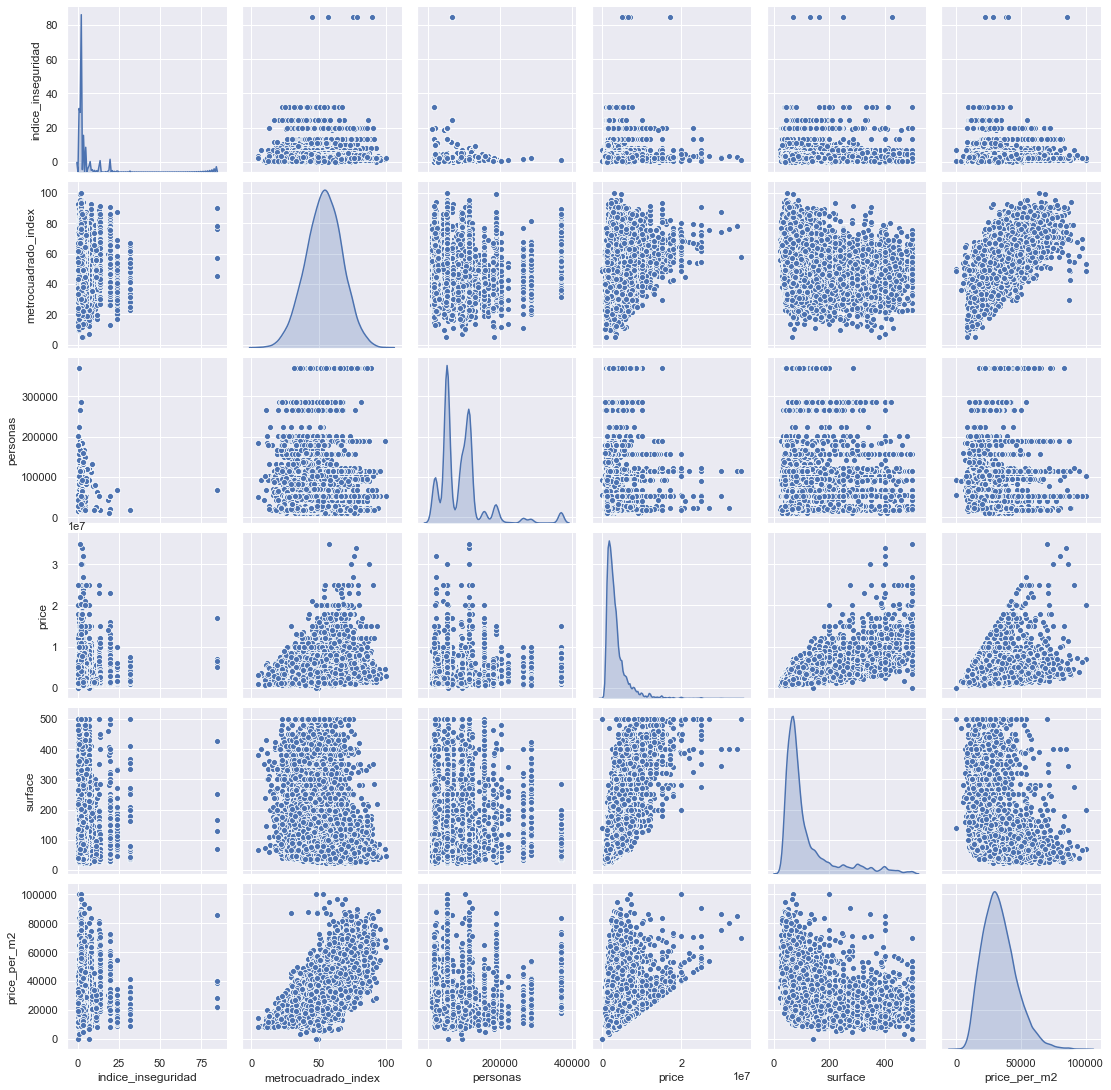

In [110]:
data = df.reindex(idxs, axis=1).droplevel(0,axis=1).dropna()
sns.pairplot(data=data, diag_kind='kde')

In [111]:
'''Veamos correlacion entre variables
'''
corrmatrix = df.corr()
corrmatrix

numeric            \
                                                      UPlArea     price   
numeric     UPlArea                                  1.000000  0.027747   
            price                                    0.027747  1.000000   
            surface                                  0.023095  0.772977   
            metrocuadrado_index                     -0.010659  0.169523   
            personas                                 0.602691  0.029735   
            trabajoinf_ninos_5_17_anos_perc         -0.115445 -0.023598   
            trabajoinfampliado_ninos_5_17_anos_perc -0.413799 -0.073641   
            jovenes_14_24_anos_nini_perc            -0.059356 -0.023463   
            indice_envegecimiento                   -0.106352  0.067842   
            jefe_mujer_perc                         -0.488944  0.072255   
            adultos_mayores_pobres_perc             -0.046152 -0.009203   
            indice_inseguridad                      -0.248719  0.003351   
            areas_verdes_perc                        0.200544  0.047721   
            densidad_poblacion                       0.019044  0.006298   
            price_per_m2                            -0.005115  0.266105   
categorical furnished                               -0.014925  0.016633   

                                                               \
                                                      surface   
numeric     UPlArea                                  0.023095   
            price                                    0.772977   
            surface                                  1.000000   
            metrocuadrado_index                     -0.207679   
            personas                                 0.062626   
            trabajoinf_ninos_5_17_anos_perc          0.033834   
            trabajoinfampliado_ninos_5_17_anos_perc -0.062283   
            jovenes_14_24_anos_nini_perc             0.059924   
            indice_envegecimiento                   -0.071768   
            jefe_mujer_perc                         -0.094548   
            adultos_mayores_pobres_perc              0.034634   
            indice_inseguridad                      -0.011134   
            areas_verdes_perc                        0.090240   
            densidad_poblacion                       0.074684   
            price_per_m2                            -0.262104   
categorical furnished                               -0.117715   

                                                                         \
                                                    metrocuadrado_index   
numeric     UPlArea                                           -0.010659   
            price                                              0.169523   
            surface                                           -0.207679   
            metrocuadrado_index                                1.000000   
            personas                                          -0.050472   
            trabajoinf_ninos_5_17_anos_perc                   -0.065176   
            trabajoinfampliado_ninos_5_17_anos_perc            0.016232   
            jovenes_14_24_anos_nini_perc                      -0.113050   
            indice_envegecimiento                              0.196432   
            jefe_mujer_perc                                    0.250163   
            adultos_mayores_pobres_perc                       -0.055714   
            indice_inseguridad                                 0.014241   
            areas_verdes_perc                                 -0.077756   
            densidad_poblacion                                -0.089901   
            price_per_m2                                       0.682398   
categorical furnished                                          0.232640   

                                                               \
                                                     personas   
numeric     UPlArea                                

In [112]:
col= indexer(['price_per_m2'])
corrmatrix[col].nlargest(20,col)

numeric
                                                    price_per_m2
numeric     price_per_m2                                1.000000
            metrocuadrado_index                         0.682398
categorical furnished                                   0.349109
numeric     jefe_mujer_perc                             0.330641
            price                                       0.266105
            indice_envegecimiento                       0.254868
            trabajoinfampliado_ninos_5_17_anos_perc     0.017619
            indice_inseguridad                          0.015364
            UPlArea                                    -0.005115
            adultos_mayores_pobres_perc                -0.060912
            personas                                   -0.066836
            trabajoinf_ninos_5_17_anos_perc            -0.097965
            areas_verdes_perc                          -0.105482
            densidad_poblacion                         -0.123121
            jovenes_14_24_anos_nini_perc               -0.144082
            surface                                    -0.262104

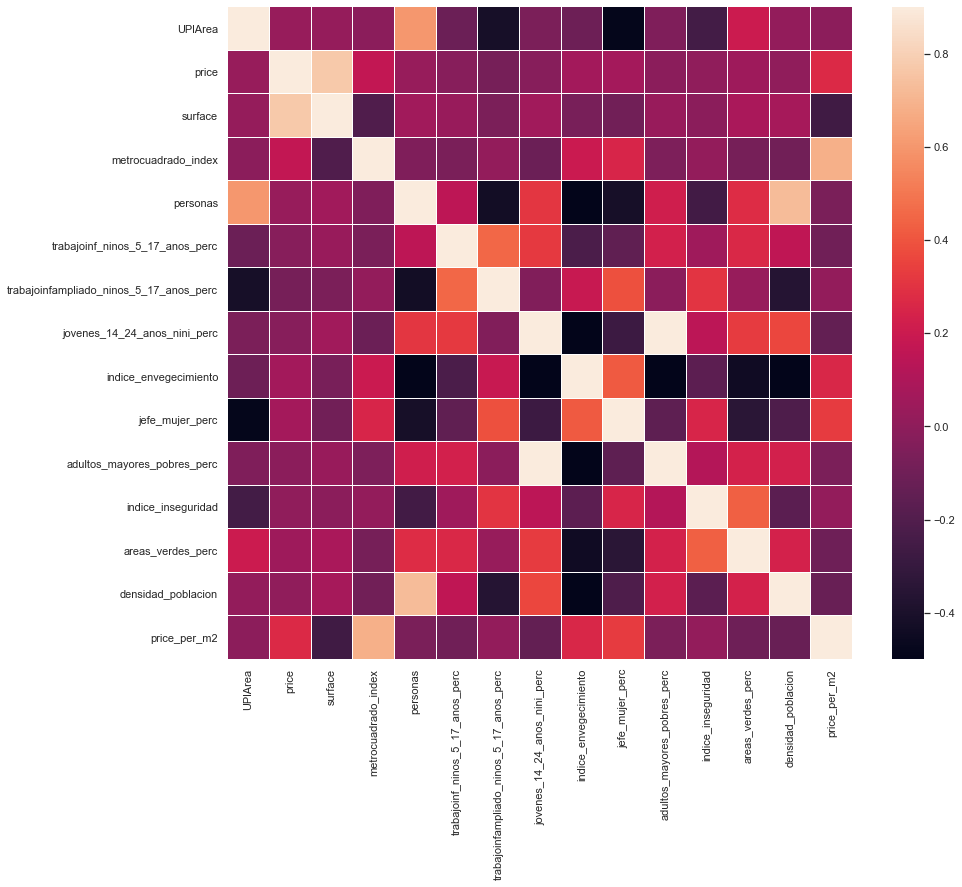

In [114]:
'''
En primera instancia analizamos la correlación entre todas
las variables numéricas mediante un mapa de calor
(la varible objetivo están en la última fila).
'''
corrmat = df['numeric'].corr()
columnas = list(corrmat.columns)

corrmat = corrmat.reindex(index = columnas, columns = columnas)

fig, ax = plt.subplots(figsize=[14, 12])

sns.heatmap(corrmat, vmin=-.5, vmax=.9, linewidths=.01)

In [117]:
'''
Se puede apreciar alta correlación (positiva y engativa)
entre algunos pares de variables.Para ubicarlos hacemos un
rearreglo 1D multi-índice y buscamos los que tengan
módulo más alto (distinto de 1).
'''
unoD=corrmat.stack()
unoD[unoD[unoD<1].abs().nlargest(20).index][::2]

jovenes_14_24_anos_nini_perc  adultos_mayores_pobres_perc    0.905176
                              indice_envegecimiento         -0.870089
price                         surface                        0.772977
personas                      densidad_poblacion             0.727243
indice_envegecimiento         adultos_mayores_pobres_perc   -0.710378
metrocuadrado_index           price_per_m2                   0.682398
UPlArea                       personas                       0.602691
indice_envegecimiento         densidad_poblacion            -0.532439
personas                      indice_envegecimiento         -0.505813
UPlArea                       jefe_mujer_perc               -0.488944
dtype: float64

In [121]:
'''
En vista de lo anterior notamos una estrecha relación entre

- jovenes_14_24_anos_nini_perc
- adultos_mayores_pobres_perc
- indice_envegecimiento

- 'personas'
- 'densidad_poblacion'

de las cuales elegimos una de cada grupo (la última) para
evitar colinearidad.

Cabe destacar que el par ('price','surface')
también tiene un valor muy alto, pero como estas variables
no se considerarán al momento de estimar 'price_per_m2' al
ser las generadoras de esta variable, no se estudia con
mayor detalle.

Por otro lado vemos que 'metrocuadrado_index'
tiene una alta correlación con la variable a explicar, por lo
que es un buen candidato para la selección final. Para ver este
fenómeno co

'''
corrmat['price_per_m2'].abs().nlargest(20)

ValueError: keep must be either "first", "last" or "all"